In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import scipy
import random

In [2]:
data_train = pd.read_csv('data_train.csv')

In [3]:
# Define the device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Create a PyTorch dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class SleepDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.from_numpy(self.sequences[idx]).float(), torch.from_numpy(np.array(self.labels[idx])).float()

In [4]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Create a function to impute the missing values in the dataset
def impute_missing_values (dataframe, method = 'LOCF', limit = 20):

    # create a missing mask (column) fthat would indicate whether the values in any of the columns of mydata are missing
    # 1 indicates missing, 0 indicates not missing
    missing_mask = dataframe.isnull().sum(axis=1).astype(bool).astype(int)
    dataframe_imputed = dataframe.copy()
    dataframe_imputed = pd.concat([dataframe_imputed, missing_mask.rename('ifmissing')], axis=1)

    if method == 'LOCF': 

        dataframe_imputed.fillna(method='ffill', inplace=True, limit = limit)

        # fill the rest with backward fill 
        dataframe_imputed.fillna(method='bfill', inplace=True, limit = limit)

    elif method =='NOCB':

        dataframe_imputed.fillna(method='bfill', inplace=True, limit = limit)

        # fill the rest with forward fill
        #dataframe_imputed.fillna(method='ffill', inplace=True, limit = limit)

    elif method == 'linear interpolation':
            
        dataframe_imputed.interpolate(method='linear', inplace=True, limit = limit)

    elif method == 'quadratic interpolation':

        dataframe_imputed.interpolate(method='quadratic', inplace=True, limit = limit)

    elif method == 'mean':

        dataframe_imputed.fillna(dataframe.mean(), inplace=True, limit = limit)

    elif method == 'median':

        dataframe_imputed.fillna(dataframe.median(), inplace=True, limit = limit)

    elif method == 'MICE':

        # Define an imputer
        imp = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=0),
                            missing_values=np.nan, 
                            sample_posterior=False,
                            max_iter=10, 
                            random_state=0, 
                            verbose=2)
                            

        columns = dataframe_imputed.columns

        # Apply the imputer
        df_imputed = imp.fit_transform(dataframe_imputed)

        # Convert back to DataFrame
        dataframe_imputed = pd.DataFrame(df_imputed, columns=columns)
    
    elif method == 'None':
        dataframe_imputed = dataframe_imputed

    missing_mask_new = dataframe_imputed.isnull().sum(axis=1).astype(bool).astype(int)

    dataframe_imputed = pd.concat([dataframe_imputed, missing_mask_new.rename('ifmissing_after_imputation')], axis=1)

    return dataframe_imputed


In [5]:


# Create a function for creating sliding windows of selected length 

def create_sliding_windows(data,  window_size_minutes=5, 
                           ifmissing = True, random_seed = 42, ifoutputsubjects = 0, 
                           train_proportion = 0.6, ifoutput_end_points = 0, 
                           resampling_method = None, resampling_proportion = 0.5, iftest = True):

    # Assert whether therea are any NaNs in the data
    if not ifmissing:
        assert data.isnull().sum().sum() == 0, "There are NaNs in the data"

    
    # Create a list of all unique subjects
    subjects = data['Sbj_ID'].unique()

    # Randomly select some of the 80% of subjects to be in the training set, 20% to the validation set and 20% in the test set
    np.random.seed(random_seed)


    train_subjects = np.random.choice(subjects, size=int(train_proportion*len(subjects)), replace=False)
    

    if iftest == 1:
        val_proportions = (1 - train_proportion)/2
        val_subjects = np.random.choice(np.setdiff1d(subjects, train_subjects), size=int(val_proportions*len(subjects)), replace=False)
        test_subjects = np.setdiff1d(subjects, np.concatenate((train_subjects, val_subjects)))
    else: 
        val_proportions = 1 - train_proportion
        val_subjects = np.setdiff1d(subjects, train_subjects)
        test_subjects = []

    
    
    # Print the number of subjects in each set
    print(f'There are {len(train_subjects)} subjects in the training set, {len(val_subjects)} subjects in the validation set and {len(test_subjects)} subjects in the test set')
    
    
    # Create a new column in the dataframe that indicates whether the subject is in the training set, val set or the test set
    data['Set'] = 'train'
    data.loc[data['Sbj_ID'].isin(val_subjects), 'Set'] = 'val'
    data.loc[data['Sbj_ID'].isin(test_subjects), 'Set'] = 'test'

    # Sort your dataframe by Sbj_ID if not already sorted
    data = data.sort_values('Sbj_ID')

    # Convert the window size from minutes to 6-second epochs
    window_size = int((window_size_minutes*60)/6)

    # Create empty lists to store your sequences and labels
    train_sequences = []
    train_labels = []
    val_sequences = []
    val_labels = []
    test_sequences = []
    test_labels = []

    # Group the DataFrame by subject ID and iterate over each group, dividing into training and test sets
    if ifoutput_end_points == 1:
        test_end_points = []
        test_sleep_stages = []
        test_labels = []
        val_sleep_stages = []
        val_end_points = []
    for _, group in data.groupby('Sbj_ID'):
        
        # For each group, get the feature columns and convert them into numpy array
        if ifoutput_end_points == 1:
             group_features = group.drop(['Sbj_ID', 'Label', 'Set', 'ifmissing_after_imputation', 'Old_label', 'ifCleanOnset', 'Time2Sleep', 'SleepStage'], axis=1).to_numpy()
             group_old_labels = group['Old_label'].to_numpy()
             group_sleep_stages = group['SleepStage'].to_numpy()
             group_labels = group['Label'].to_numpy()
        else:
            group_features = group.drop(['Sbj_ID', 'Label', 'Set', 'ifmissing_after_imputation', 'ifCleanOnset', 'Time2Sleep', 'SleepStage'], axis=1).to_numpy()

        ifmissing_column = group['ifmissing_after_imputation'].to_numpy()

        train_test = group['Set'].iloc[0]
        
        if window_size == len(group_features):
            if train_test == 'train':
                print('got here')
                train_sequences.append(group_features)
                train_labels.append(group['Label'].iloc[0])
            elif train_test == 'val':
                val_sequences.append(group_features)
                val_labels.append(group['Label'].iloc[0])
            elif train_test == 'test':
                test_sequences.append(group_features)
                test_labels.append(group['Label'].iloc[0])
        elif window_size > len(group_features):
            continue

       
        # Iterate over the group array with a sliding window
        for i in range(len(group_features) - window_size):
            
            # If there are any NaNs in the window, skip it
            if ifmissing_column[i : i + window_size].sum() > 0:
                continue

            if train_test == 'train':

                # Append the window data to your sequences
                train_sequences.append(group_features[i : i + window_size])

                # Append the label corresponding to the end of the window
                train_labels.append(group['Label'].iloc[i+window_size])

                if ifoutput_end_points == 1:
                    # Append the starting point of the window to the list of starting points
                    test_end_points.append(group_old_labels[i+window_size])
                    test_sleep_stages.append(group_sleep_stages[i+window_size])
            
            elif train_test == 'val':
                # Append the window data to your sequences
                val_sequences.append(group_features[i : i + window_size])

                # Append the label corresponding to the end of the window
                val_labels.append(group['Label'].iloc[i+window_size])

                if ifoutput_end_points == 1:
                    # Append the starting point of the window to the list of starting points
                    val_end_points.append(group_old_labels[i+window_size])
                    val_sleep_stages.append(group_sleep_stages[i+window_size])
            

            elif train_test == 'test':
                
                # Append the window data to your sequences
                test_sequences.append(group_features[i : i + window_size])

                # Append the label corresponding to the end of the window
                test_labels.append(group['Label'].iloc[i+window_size])
                        
            
    # Convert the sequences and labels into numpy arrays
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)
    val_sequences = np.array(val_sequences)
    val_labels = np.array(val_labels)
    test_sequences = np.array(test_sequences)
    test_labels = np.array(test_labels)

    
    if iftest == 1:
        if ifoutputsubjects:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, train_subjects, val_subjects, test_subjects, test_end_points, test_sleep_stages
            else: 
                return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, train_subjects, val_subjects, test_subjects
        else:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, test_end_points, test_sleep_stages
            else:
                return train_sequences, train_labels, val_sequences, val_labels,  test_sequences, test_labels
    else:
        if ifoutputsubjects:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels,  train_subjects, val_subjects, val_end_points, val_sleep_stages
            else: 
                return train_sequences, train_labels, val_sequences, val_labels, train_subjects, val_subjects
            
        else:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels, val_end_points, val_sleep_stages
            else:
                return train_sequences, train_labels, val_sequences, val_labels


In [6]:
import torch
from sklearn.metrics import mean_squared_error, r2_score

# Train function
def train_regression(model, train_loader, val_loader, num_epochs, criterion, optimizer, device, ifplot = False):

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):

        print ('Epoch {}/{}'.format(epoch+1, num_epochs))

        # Train the model
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
           
            inputs, labels = inputs.permute(1, 0, 2).to(device), labels.to(device)
            # Your training steps...

            # Forward pass
            outputs = model(inputs)

            loss = criterion(outputs, labels.view(-1, 1))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validate the model
        model.eval()
        with torch.no_grad():
            val_loss = 0
            predictions, actuals = [], []
            for inputs, labels in val_loader:
                inputs, labels = inputs.permute(1, 0, 2).to(device), labels.to(device)
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)  # these are outputs now
                val_loss += criterion(outputs, labels.view(-1, 1)).item()

                predictions.extend(outputs.cpu().numpy().flatten())
                actuals.extend(labels.cpu().numpy())    

            # Calculate metrics
            mse = mean_squared_error(actuals, predictions)
            r2 = r2_score(actuals, predictions)
            mae = mean_absolute_error(actuals, predictions)

            if ifplot:
                print('-'*100)
                print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss/len(val_loader)}')
                print(f'Val Mean Squared Error: {mse}, Val R2 Score: {r2}')

                

        # Save the model training and validation losses for plotting 
        train_losses.append(loss.item())
        val_losses.append(val_loss/len(val_loader))

    return train_losses, val_losses, model, optimizer, mse, r2, mae

# Test function
def test_regression(model, test_loader, device, criterion):
    model.eval()
    predictions, actuals = [], []
    
    with torch.no_grad():
        test_loss = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.permute(1, 0, 2).to(device), labels.to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # these are outputs now
            test_loss += criterion(outputs, labels.view(-1, 1)).item()

            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(labels.cpu().numpy())

        print(f'Test Loss: {test_loss/len(test_loader)}')

    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)

    print('Mean Squared Error:', mse)
    print('R2 Score:', r2)
    print('Mean Absolute Error:', mae)

    return predictions, actuals, mse, r2, mae

In [7]:
def evaluate_performance_test(predictions, y_test):

    # check if the predictions are in the correct format
    if type(predictions) == list:
        predictions = np.array(predictions)

    # check if the y_test is in the correct format
    if type(y_test) == list:
        y_test = np.array(y_test)

    errors = abs(y_test - predictions)
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    mse = sklearn.metrics.mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = sklearn.metrics.r2_score(y_test, predictions)


    print('Mean Absolute Error:', round(np.mean(errors), 2))
    print('Accuracy:', round(accuracy, 2), '%.')
    print('Mean Squared Error:', round(mse, 2))
    print('Root Mean Squared Error:', round(rmse, 2))
    print('R2:', round(r2, 2))
    


    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    plt.scatter(y_test, predictions, alpha=0.2)
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Predicted time to sleep onset')
    plt.title('Actual vs Predicted time to sleep onset')
    plt.show()
    plt.close()

    residuals = y_test - predictions
    plt.scatter(y_test, residuals, alpha=0.2)
    plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1)
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Residuals')
    plt.title('Actual vs Residuals')
    plt.show()
    plt.close()

    plt.hist(residuals)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residuals distribution')
    plt.show()
    plt.close()

    # for each actual, plot the mean residual 
    # round y_test to 0.1 decimal place
    y_test = np.round(y_test, 1)

    predictions_residuals_dict = {}
    for i in range(len(y_test)):
        if y_test[i] not in predictions_residuals_dict:
            predictions_residuals_dict[y_test[i]] = []
        predictions_residuals_dict[y_test[i]].append(residuals[i])
    
    # sort it in ascending order of keys
    predictions_residuals_dict = dict(sorted(predictions_residuals_dict.items()))


    actual_predictions_dict = {}
    for i in range(len(y_test)):
        if y_test[i] not in actual_predictions_dict:
            actual_predictions_dict[y_test[i]] = []
        actual_predictions_dict[y_test[i]].append(predictions[i])
    
    # sort it in ascending order of keys
    actual_predictions_dict = dict(sorted(actual_predictions_dict.items()))

    
    predictions_residuals_mean_dict = {}
    for key in predictions_residuals_dict:
        predictions_residuals_mean_dict[key] = np.mean(predictions_residuals_dict[key])
    
    # sort it in ascending order of keys
    predictions_residuals_mean_dict = dict(sorted(predictions_residuals_mean_dict.items()))


    residuals_std_dict = {}
    for key in predictions_residuals_dict:
        residuals_std_dict[key] = np.std(predictions_residuals_dict[key])
    # sort it in ascending order of keys
    residuals_std_dict = dict(sorted(residuals_std_dict.items()))

    
    actuals_predictions_mean_dict = {}
    for key in actual_predictions_dict:
        actuals_predictions_mean_dict[key] = np.mean(actual_predictions_dict[key])
    
    # sort it in ascending order of keys
    actuals_predictions_mean_dict = dict(sorted(actuals_predictions_mean_dict.items()))

    predictions_std_dict = {}
    for key in actual_predictions_dict:
        predictions_std_dict[key] = np.std(actual_predictions_dict[key])
    # sort it in ascending order of keys
    predictions_std_dict = dict(sorted(predictions_std_dict.items()))

    plt.plot(list(predictions_residuals_mean_dict.keys()), list(predictions_residuals_mean_dict.values()))
    # create std shading
    plt.fill_between(list(predictions_residuals_mean_dict.keys()),
                        np.array(list(predictions_residuals_mean_dict.values())) - np.array(list(residuals_std_dict.values())),
                        np.array(list(predictions_residuals_mean_dict.values())) + np.array(list(residuals_std_dict.values())),
                        alpha=0.2)
    # plot ideal line (x = 0)
    plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Mean Residuals for this actual')
    plt.title('Actual vs Residuals')
    plt.show()

    plt.plot(list(actuals_predictions_mean_dict.keys()), list(actuals_predictions_mean_dict.values()))
    # create std shading
    plt.fill_between(list(actuals_predictions_mean_dict.keys()),
                        np.array(list(actuals_predictions_mean_dict.values())) - np.array(list(predictions_std_dict.values())),
                        np.array(list(actuals_predictions_mean_dict.values())) + np.array(list(predictions_std_dict.values())),
                        alpha=0.2)
    # plot ideal line (x = y)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Mean Prediction for this actual')
    plt.title('Actual vs Predictions')
    plt.show()

    return predictions, errors, mape, accuracy, residuals

In [8]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class SleepOnsetTransformerRegressor(nn.Module):
    def __init__(self, input_size, nhead, num_layers, output_size=1, dropout=0.0):
        super(SleepOnsetTransformerRegressor, self).__init__()
        
        self.embedding = nn.Linear(input_size, 512) # Convert input features to suitable size for Transformer
        self.positional_encoding = PositionalEncoding(512, dropout)
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(d_model=512, nhead=nhead, dropout=dropout),
            num_layers=num_layers
        )
        
        self.fc = nn.Linear(512, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        out = self.fc(x[-1, :, :])  # using the last sequence output for regression prediction
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SleepOnsetTransformerRegressor(input_size=10, nhead=8, num_layers=2).to(device)



In [9]:
from sklearn.metrics import mean_squared_error

def training_loop_feature_RNN_regression(mydata, filling_limit, method, input_size, num_epochs,
                                        lr, weight_decay, batch_size, device, 
                                        nhead = 3, num_layers = 2, l2 = 0.01,
                                         random_seed=42, window_size_minutes=1, 
                                         iftest=False, ifoutputpredictions=0, 
                                         ifplot=False, ifsaveplots=True, output_path=None, loss_function = None,
                                         iftrainshuffle = False):

    # First, impute the missing values in the dataset
    mydata_imputed = impute_missing_values(mydata, method=method, limit=filling_limit)

    # Check if the dataset still has any missing values
    ifmissing = mydata_imputed.isnull().sum().sum()

   # Depending on the 'ifprobabilitiesanalysis' flag, process the data differently
    if iftest:
        train_sequences, train_targets, val_sequences, val_targets, test_sequences, test_targets = create_sliding_windows(mydata_imputed,  window_size_minutes=window_size_minutes,
                                                                                                                    ifmissing = ifmissing, random_seed = 42, ifoutputsubjects = 0, 
                                                                                                                    train_proportion = 0.9, ifoutput_end_points = 0,
                                                                                                                    resampling_method = None, resampling_proportion = 0.5, iftest = iftest)
    else:   
        train_sequences, train_targets, val_sequences, val_targets = create_sliding_windows(mydata_imputed,  window_size_minutes=window_size_minutes,
                                                                                                                    ifmissing = ifmissing, random_seed = 42, ifoutputsubjects = 0, 
                                                                                                                    train_proportion = 0.9, ifoutput_end_points = 0,
                                                                                                                    resampling_method = None, resampling_proportion = 0.5, iftest = iftest)
      
    
    # Define the loss function for regression
    if loss_function is None:
        criterion = nn.MSELoss()
    else:
        criterion = loss_function

    
    # Create the training, validation, and test datasets
    train_dataset = SleepDataset(train_sequences, train_targets)
    val_dataset = SleepDataset(val_sequences, val_targets)
    if iftest:
        test_dataset = SleepDataset(test_sequences, test_targets)

    # Create the data loaders
    if iftrainshuffle:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle =True)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle =False)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    if iftest:
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    # Initialize the model (This model needs to be defined as a regression model)
    model = SleepOnsetTransformerRegressor(input_size=input_size, nhead = nhead,  num_layers = num_layers)

    # Define the optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train the model
    train_losses, val_losses, model, optimizer, mse, r2, mae= train_regression(model=model, train_loader=train_loader, val_loader=val_loader, device=device, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs, ifplot=ifplot)
    # Plot the training and validation losses
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()
    
    plt.show()
    plt.close()

    # Test the trained model if necessary
    if iftest == 1:
        predictions, actuals, mse, r2, mae = test_regression(model=model, test_loader=test_loader, device=device, criterion=criterion)
        #mse = mean_squared_error(actuals, predictions)
        print("Test MSE:", mse)
        print("Test R2:", r2)
        print("Test MAE:", mae)

        evaluate_performance_test(predictions, actuals)

    else:
        predictions, actuals, mse, r2, mae = test_regression(model=model, test_loader=val_loader, device=device, criterion=criterion)
        #mse = mean_squared_error(actuals, predictions)
        print("Test MSE:", mse)
        print("Test R2:", r2)
        print("Test MAE:", mae)

        evaluate_performance_test(predictions, actuals)
        if ifoutputpredictions:
            return train_losses, val_losses, model, predictions, actuals, mse
        else:
            return train_losses, val_losses, model


## Regression from pretrained model

In [10]:
data_clean_onset = pd.read_csv('data_perfectly_clean_train.csv')

There are 193 subjects in the training set, 22 subjects in the validation set and 0 subjects in the test set
Epoch 1/30
----------------------------------------------------------------------------------------------------
Epoch 1/30, Loss: 21.575525283813477, Validation Loss: 69.22560255474514
Val Mean Squared Error: 69.34432220458984, Val R2 Score: 0.14743333957609772
Epoch 2/30
----------------------------------------------------------------------------------------------------
Epoch 2/30, Loss: 35.49814224243164, Validation Loss: 69.20490440620317
Val Mean Squared Error: 69.31027221679688, Val R2 Score: 0.14785197611839596
Epoch 3/30
----------------------------------------------------------------------------------------------------
Epoch 3/30, Loss: 26.19114112854004, Validation Loss: 68.55659190098444
Val Mean Squared Error: 68.69068145751953, Val R2 Score: 0.1554696758973778
Epoch 4/30
-------------------------------------------------------------------------------------------------

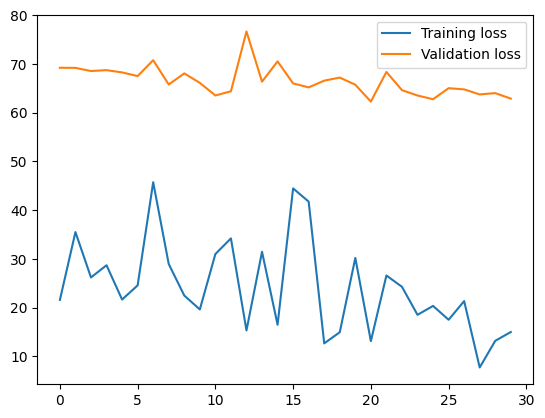

Test Loss: 62.898414539032515
Mean Squared Error: 63.047253
R2 Score: 0.22485380743186656
Mean Absolute Error: 6.40614
Test MSE: 63.047253
Test R2: 0.22485380743186656
Test MAE: 6.40614
Mean Absolute Error: 6.41
Accuracy: -inf %.
Mean Squared Error: 63.05
Root Mean Squared Error: 7.94
R2: 0.22


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


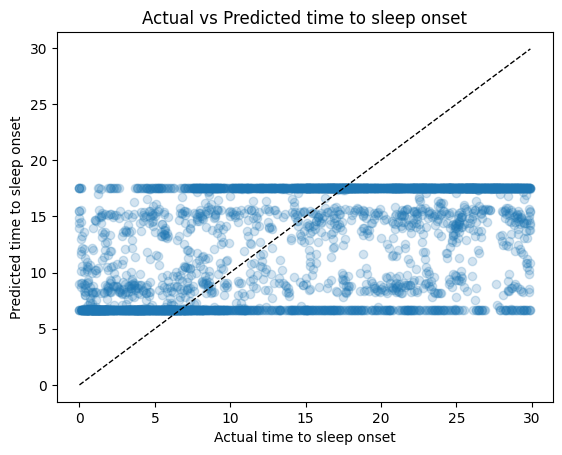

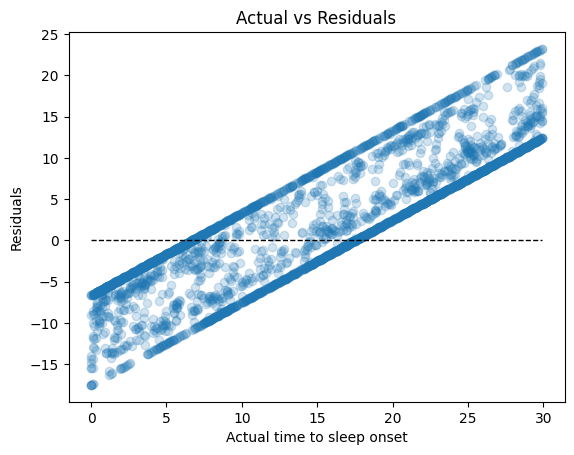

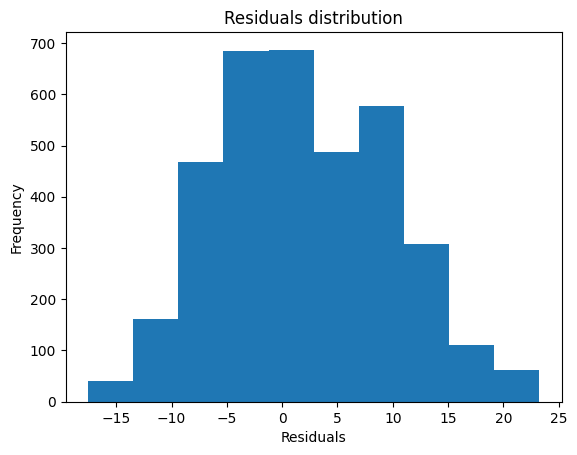

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


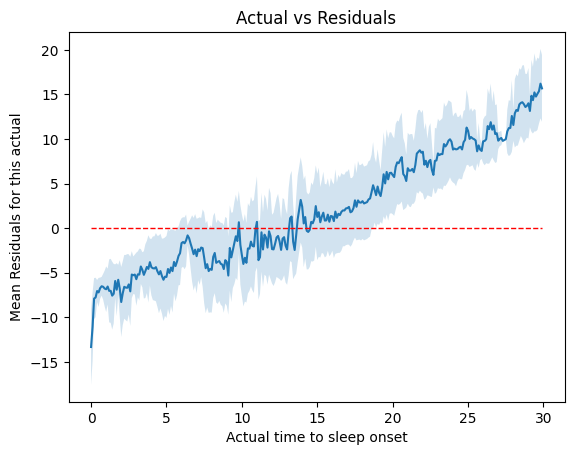

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


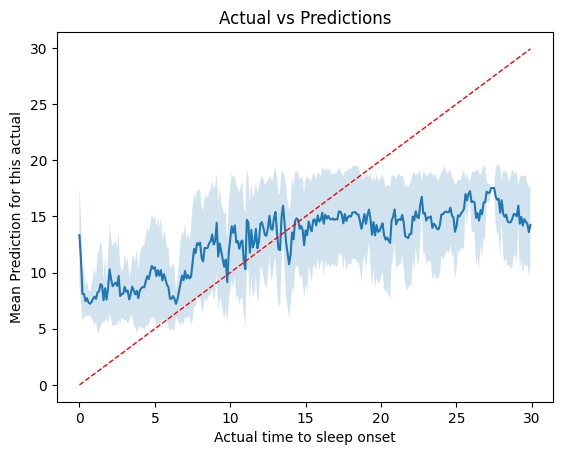

([21.575525283813477,
  35.49814224243164,
  26.19114112854004,
  28.690635681152344,
  21.649192810058594,
  24.559864044189453,
  45.7297477722168,
  28.94470977783203,
  22.471660614013672,
  19.617137908935547,
  30.991600036621094,
  34.20423889160156,
  15.311041831970215,
  31.450307846069336,
  16.479103088378906,
  44.46435546875,
  41.74991226196289,
  12.65098762512207,
  14.942533493041992,
  30.192609786987305,
  13.11876392364502,
  26.585142135620117,
  24.266210556030273,
  18.51449203491211,
  20.34468650817871,
  17.500595092773438,
  21.333694458007812,
  7.7060394287109375,
  13.182785987854004,
  14.985743522644043],
 [69.22560255474514,
  69.20490440620317,
  68.55659190098444,
  68.73759321000841,
  68.27244760990143,
  67.51657546050019,
  70.78186317178938,
  65.79442355765237,
  68.07066488107046,
  66.12691945367389,
  63.53884863058726,
  64.4034331923061,
  76.6755362314648,
  66.37273927344216,
  70.5382528175248,
  66.01322608921262,
  65.19950840261248,


In [11]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead= 4,
                                        num_layers = 2, num_epochs = 30, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=False, ifoutputpredictions=0, 
                                        ifplot=True, ifsaveplots=True, output_path=None)

There are 193 subjects in the training set, 22 subjects in the validation set and 0 subjects in the test set
Epoch 1/5
----------------------------------------------------------------------------------------------------
Epoch 1/5, Loss: 29.38901138305664, Validation Loss: 72.88903078503078
Val Mean Squared Error: 72.98847198486328, Val R2 Score: 0.10262976313069405
Epoch 2/5
----------------------------------------------------------------------------------------------------
Epoch 2/5, Loss: 24.25615119934082, Validation Loss: 71.77413073539734
Val Mean Squared Error: 71.86666870117188, Val R2 Score: 0.11642181187121936
Epoch 3/5
----------------------------------------------------------------------------------------------------
Epoch 3/5, Loss: 22.1402587890625, Validation Loss: 65.5290081999037
Val Mean Squared Error: 65.65067291259766, Val R2 Score: 0.19284556120749385
Epoch 4/5
----------------------------------------------------------------------------------------------------
Epoch

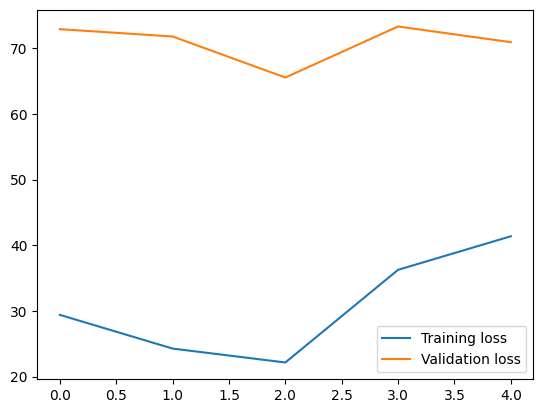

Test Loss: 70.90798436641693
Mean Squared Error: 71.0281
R2 Score: 0.1267318076959041
Mean Absolute Error: 7.011599
Test MSE: 71.0281
Test R2: 0.1267318076959041
Test MAE: 7.011599
Mean Absolute Error: 7.01
Accuracy: -inf %.
Mean Squared Error: 71.03
Root Mean Squared Error: 8.43
R2: 0.13


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


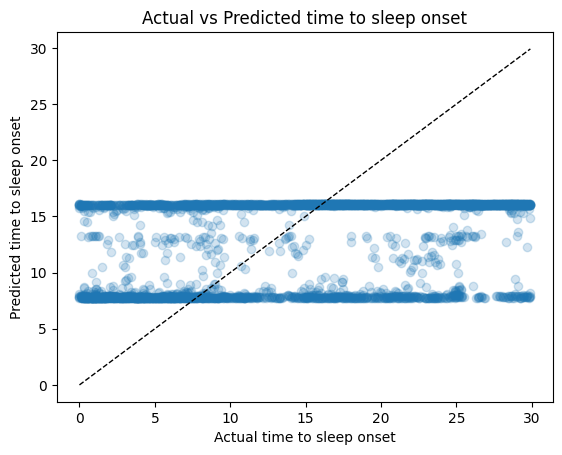

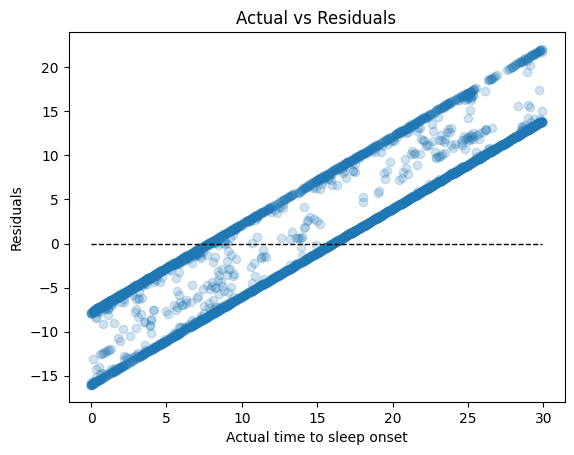

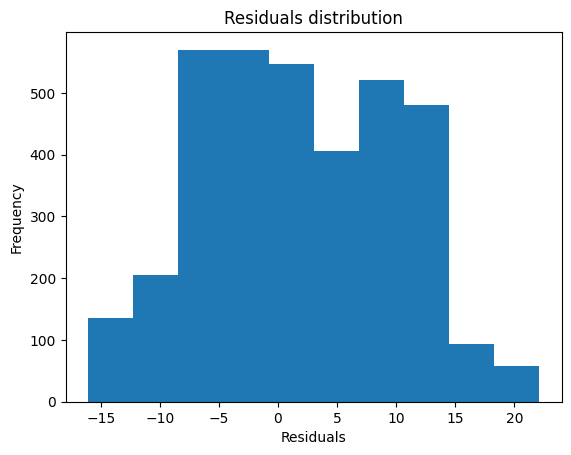

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


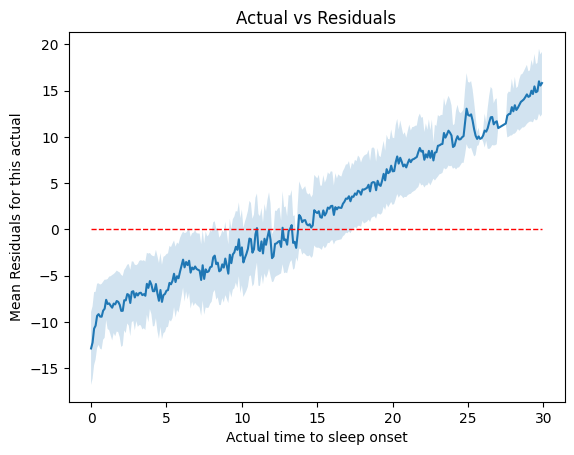

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


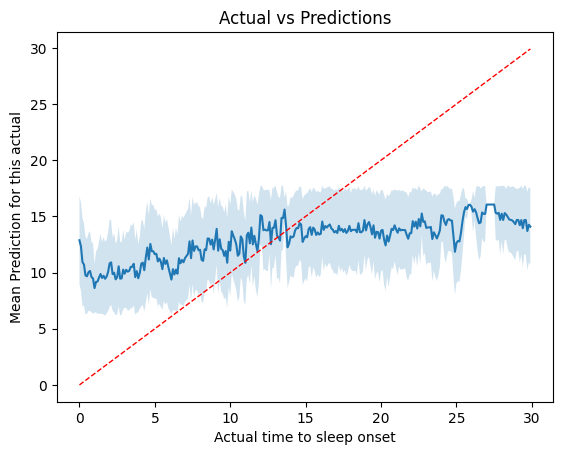

([29.38901138305664,
  24.25615119934082,
  22.1402587890625,
  36.247440338134766,
  41.35460662841797],
 [72.88903078503078,
  71.77413073539734,
  65.5290081999037,
  73.29963882340326,
  70.90798436641693],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
         )
         (linear1): Linear(in_features=512, out_features=2048, bias=True)
         (dropout): Dropout(p=0.0, inplace=False)
         (linear2): Linear(in_features=2048, out_features=512, bias=True)
         (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((512,), eps=1e-05, elem

In [12]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead= 2,
                                        num_layers = 2, num_epochs = 5, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=False, ifoutputpredictions=0, 
                                         ifplot=True, ifsaveplots=True, output_path=None)

There are 193 subjects in the training set, 22 subjects in the validation set and 0 subjects in the test set
Epoch 1/5
----------------------------------------------------------------------------------------------------
Epoch 1/5, Loss: 28.479230880737305, Validation Loss: 72.27297204640176
Val Mean Squared Error: 72.38667297363281, Val R2 Score: 0.11002865795067729
Epoch 2/5
----------------------------------------------------------------------------------------------------
Epoch 2/5, Loss: 32.28843307495117, Validation Loss: 71.24333516306348
Val Mean Squared Error: 71.3388900756836, Val R2 Score: 0.12291076236306897
Epoch 3/5
----------------------------------------------------------------------------------------------------
Epoch 3/5, Loss: 45.8892822265625, Validation Loss: 66.90482717990875
Val Mean Squared Error: 67.04781341552734, Val R2 Score: 0.17566823345872773
Epoch 4/5
----------------------------------------------------------------------------------------------------
Epoc

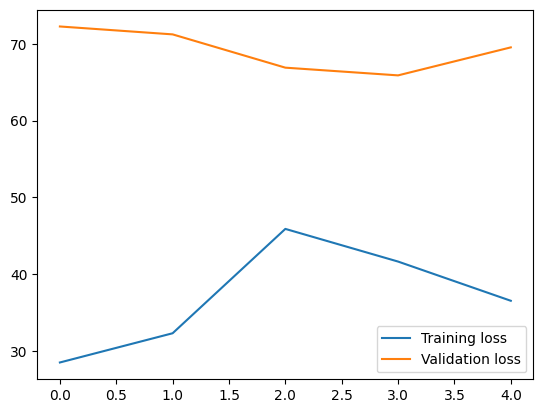

Test Loss: 69.54948009411494
Mean Squared Error: 69.67897
R2 Score: 0.1433188911994676
Mean Absolute Error: 6.7751265
Test MSE: 69.67897
Test R2: 0.1433188911994676
Test MAE: 6.7751265
Mean Absolute Error: 6.78
Accuracy: -inf %.
Mean Squared Error: 69.68
Root Mean Squared Error: 8.35
R2: 0.14


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


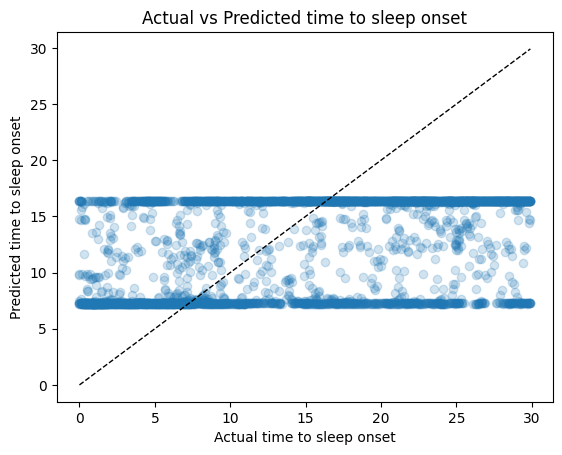

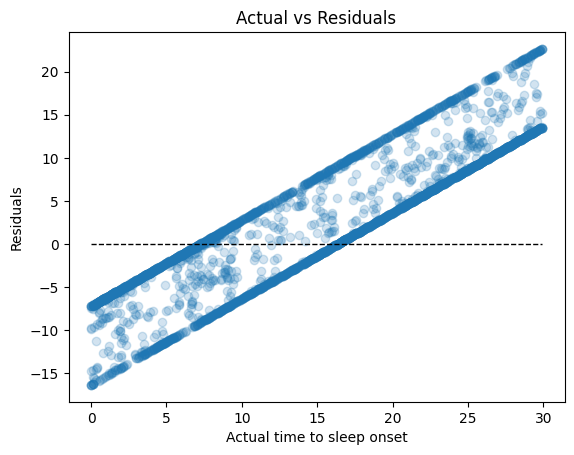

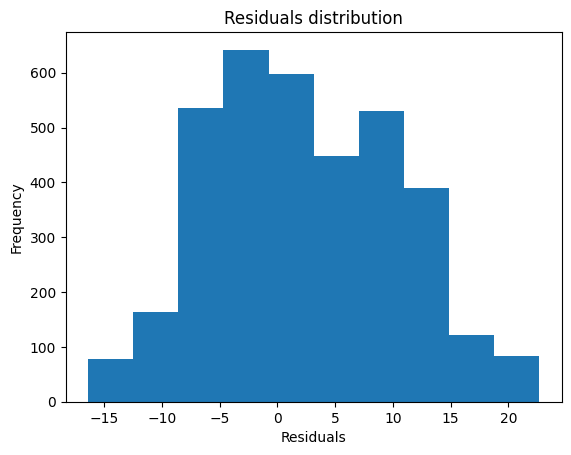

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


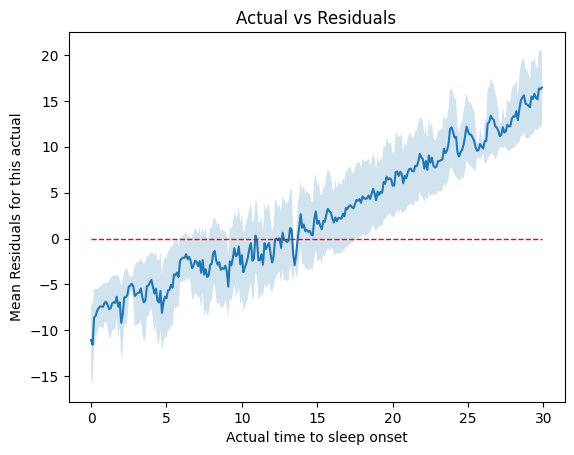

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


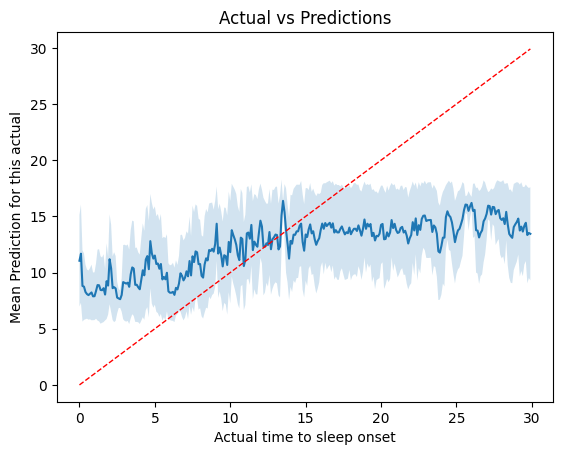

([28.479230880737305,
  32.28843307495117,
  45.8892822265625,
  41.63185119628906,
  36.52097702026367],
 [72.27297204640176,
  71.24333516306348,
  66.90482717990875,
  65.89936071501837,
  69.54948009411494],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
         )
         (linear1): Linear(in_features=512, out_features=2048, bias=True)
         (dropout): Dropout(p=0.0, inplace=False)
         (linear2): Linear(in_features=2048, out_features=512, bias=True)
         (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((512,), eps=1e-05, ele

In [13]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 2,
                                        num_layers = 2, num_epochs = 5, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=False, ifoutputpredictions=0, 
                                       ifplot=True, ifsaveplots=True, output_path=None)

There are 193 subjects in the training set, 22 subjects in the validation set and 0 subjects in the test set
Epoch 1/5
----------------------------------------------------------------------------------------------------
Epoch 1/5, Loss: 33.00162887573242, Validation Loss: 73.02919507980347
Val Mean Squared Error: 73.13034057617188, Val R2 Score: 0.10088538516770795
Epoch 2/5
----------------------------------------------------------------------------------------------------
Epoch 2/5, Loss: 31.34367561340332, Validation Loss: 73.4251701757643
Val Mean Squared Error: 73.51289367675781, Val R2 Score: 0.09618205511277156
Epoch 3/5
----------------------------------------------------------------------------------------------------
Epoch 3/5, Loss: 45.32642364501953, Validation Loss: 68.00620743963454
Val Mean Squared Error: 68.12882232666016, Val R2 Score: 0.16237749678148972
Epoch 4/5
----------------------------------------------------------------------------------------------------
Epoc

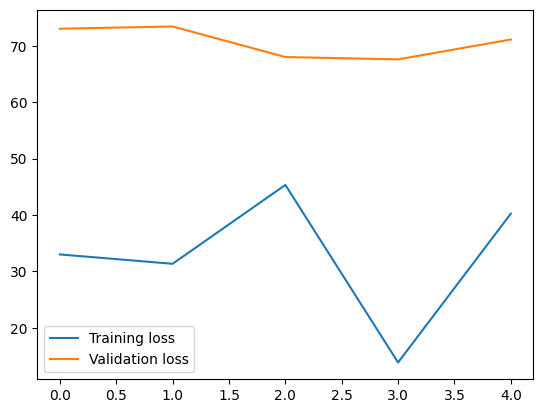

Test Loss: 71.11392392052545
Mean Squared Error: 71.23095
R2 Score: 0.12423777849656525
Mean Absolute Error: 6.9766536
Test MSE: 71.23095
Test R2: 0.12423777849656525
Test MAE: 6.9766536
Mean Absolute Error: 6.98
Accuracy: -inf %.
Mean Squared Error: 71.23
Root Mean Squared Error: 8.44
R2: 0.12


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


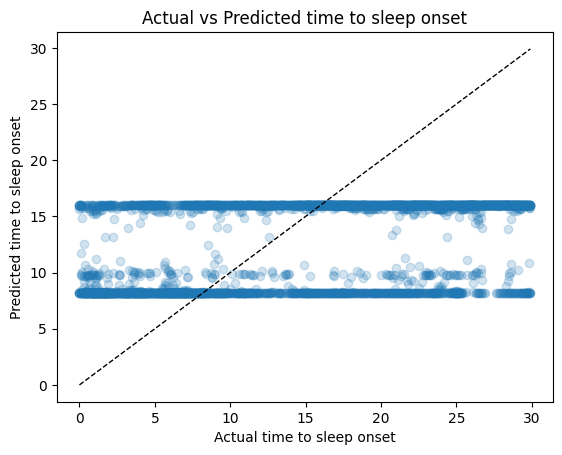

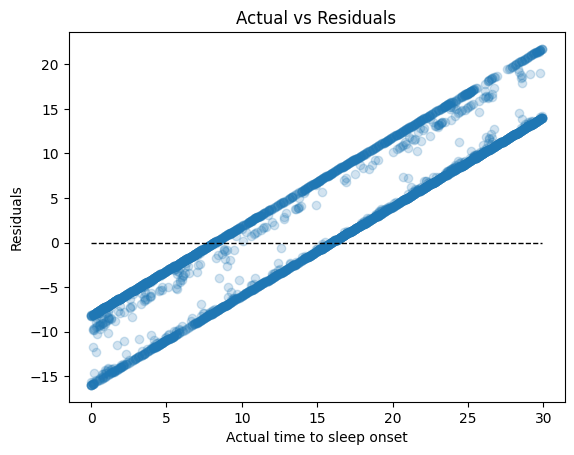

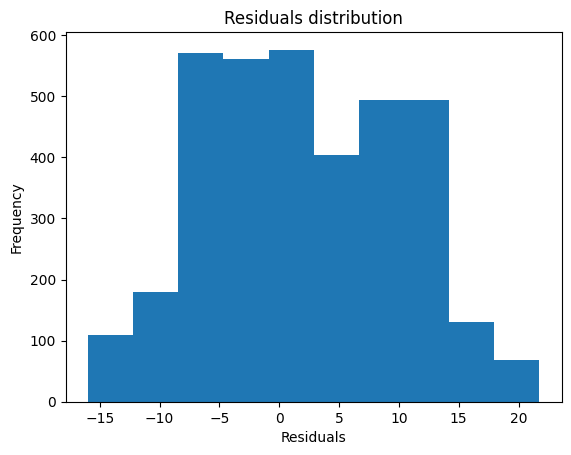

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


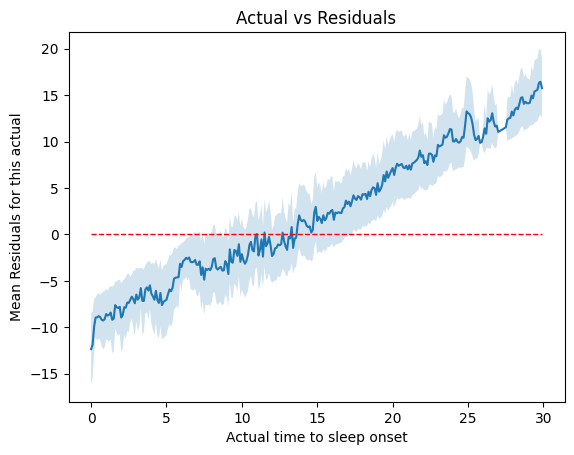

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


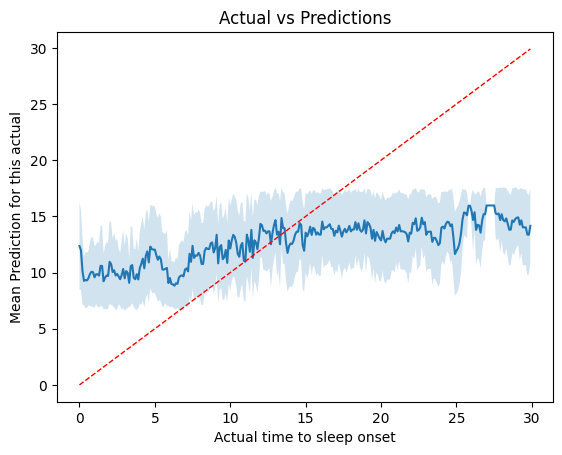

([33.00162887573242,
  31.34367561340332,
  45.32642364501953,
  13.842437744140625,
  40.23220443725586],
 [73.02919507980347,
  73.4251701757643,
  68.00620743963454,
  67.59101002931595,
  71.11392392052545],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
         )
         (linear1): Linear(in_features=512, out_features=2048, bias=True)
         (dropout): Dropout(p=0.0, inplace=False)
         (linear2): Linear(in_features=2048, out_features=512, bias=True)
         (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((512,), eps=1e-05, ele

In [14]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 5, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=False, ifoutputpredictions=0, 
                                       ifplot=True, ifsaveplots=True, output_path=None)

## Try on last 5 minutes of the clean onset

In [15]:
data_clean_5 = data_clean_onset[data_clean_onset['Label'] <= 5].copy()

In [16]:
data_clean_5

Label  Sbj_ID  Age  Gender  Race1  Race2  Race3  Race4  ifCleanOnset  \
249      5.0      12   80       1    1.0    0.0    0.0    0.0             1   
250      4.9      12   80       1    1.0    0.0    0.0    0.0             1   
251      4.8      12   80       1    1.0    0.0    0.0    0.0             1   
252      4.7      12   80       1    1.0    0.0    0.0    0.0             1   
253      4.6      12   80       1    1.0    0.0    0.0    0.0             1   
...      ...     ...  ...     ...    ...    ...    ...    ...           ...   
64495    0.4    6695   55       1    1.0    0.0    0.0    0.0             1   
64496    0.3    6695   55       1    1.0    0.0    0.0    0.0             1   
64497    0.2    6695   55       1    1.0    0.0    0.0    0.0             1   
64498    0.1    6695   55       1    1.0    0.0    0.0    0.0             1   
64499    0.0    6695   55       1    1.0    0.0    0.0    0.0             1   

       Time2Sleep  ...  wrseltr5  slpapnea5  cpap5  dntaldv5  uvula5  \
249          66.0  ...       9.0        0.0    0.0       0.0     0.0   
250          66.0  ...       9.0        0.0    0.0       0.0     0.0   
251          66.0  ...       9.0        0.0    0.0       0.0     0.0   
252          66.0  ...       9.0        0.0    0.0       0.0     0.0   
253          66.0  ...       9.0        0.0    0.0       0.0     0.0   
...           ...  ...       ...        ...    ...       ...     ...   
64495        80.5  ...      -1.0        0.0    0.0       0.0     0.0   
64496        80.5  ...      -1.0        0.0    0.0       0.0     0.0   
64497        80.5  ...      -1.0        0.0    0.0       0.0     0.0   
64498        80.5  ...      -1.0        0.0    0.0       0.0     0.0   
64499        80.5  ...      -1.0        0.0    0.0       0.0     0.0   

       insmnia5  rstlesslgs5  whiirs5c  epslpscl5c  hoostmeq5c  
249         0.0          0.0       9.0         5.0        12.0  
250         0.0          0.0       9.0         5.0        12.0  
251         0.0          0.0       9.0         5.0        12.0  
252         0.0          0.0       9.0         5.0        12.0  
253         0.0          0.0       9.0         5.0        12.0  
...         ...          ...       ...         ...         ...  
64495       0.0          0.0      15.0         2.0        12.0  
64496       0.0          0.0      15.0         2.0        12.0  
64497       0.0          0.0      15.0         2.0        12.0  
64498       0.0          0.0      15.0         2.0        12.0  
64499       0.0          0.0      15.0         2.0        12.0  

[10965 rows x 90 columns]

There are 193 subjects in the training set, 22 subjects in the validation set and 0 subjects in the test set
Epoch 1/15
----------------------------------------------------------------------------------------------------
Epoch 1/15, Loss: 7.273972511291504, Validation Loss: 2.4399966228575933
Val Mean Squared Error: 2.4402456283569336, Val R2 Score: 0.005140044475360539
Epoch 2/15
----------------------------------------------------------------------------------------------------
Epoch 2/15, Loss: 5.595456123352051, Validation Loss: 2.2038282553354898
Val Mean Squared Error: 2.203744649887085, Val R2 Score: 0.10155875861860408
Epoch 3/15
----------------------------------------------------------------------------------------------------
Epoch 3/15, Loss: 5.423276901245117, Validation Loss: 2.1389640172322593
Val Mean Squared Error: 2.1425621509552, Val R2 Score: 0.12650229775242983
Epoch 4/15
----------------------------------------------------------------------------------------------

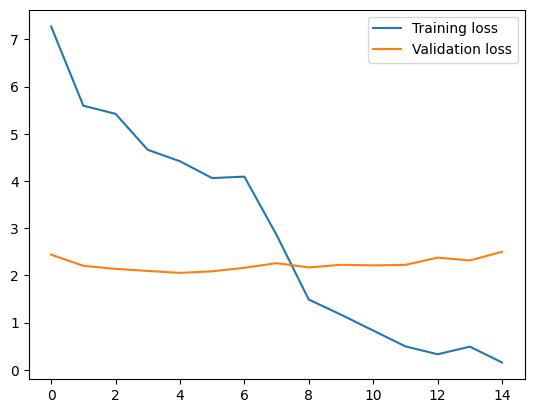

Test Loss: 2.5010078577768233
Mean Squared Error: 2.5232725
R2 Score: -0.028709069391593456
Mean Absolute Error: 1.2719525
Test MSE: 2.5232725
Test R2: -0.028709069391593456
Test MAE: 1.2719525
Mean Absolute Error: 1.27
Accuracy: -inf %.
Mean Squared Error: 2.52
Root Mean Squared Error: 1.59
R2: -0.03


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


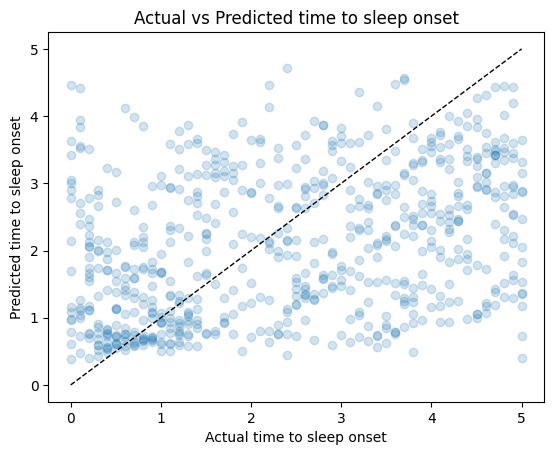

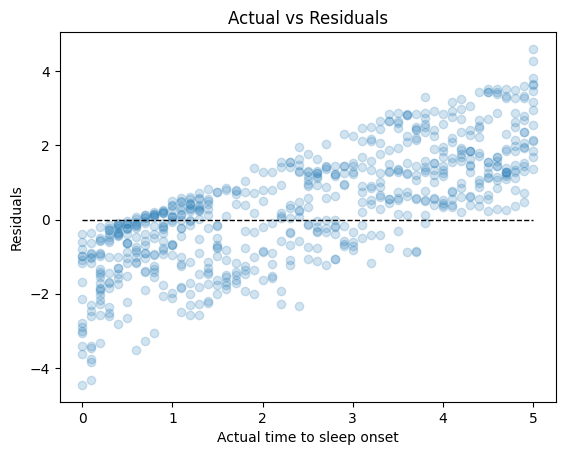

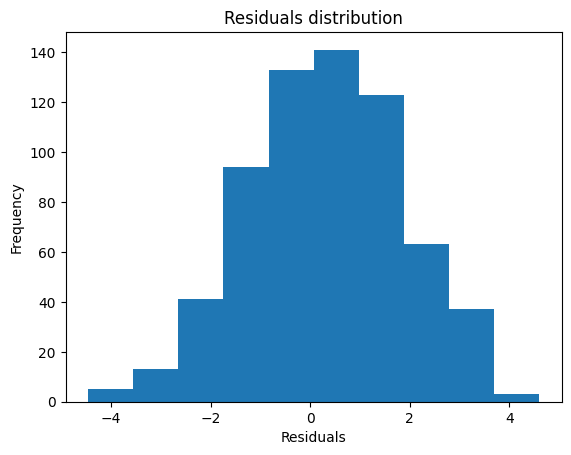

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


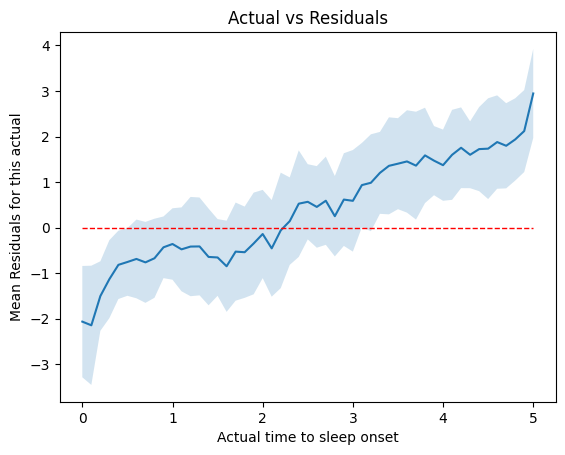

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


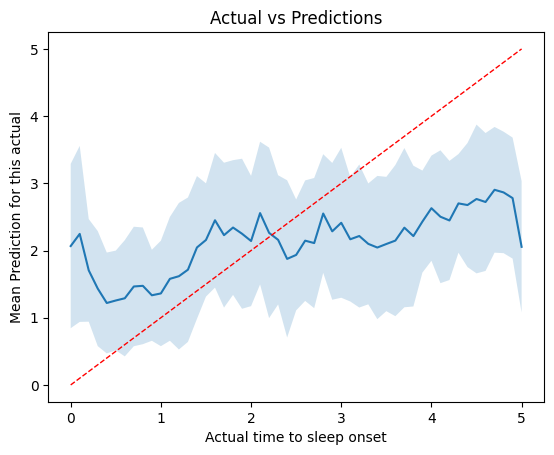

([7.273972511291504,
  5.595456123352051,
  5.423276901245117,
  4.660957336425781,
  4.418632507324219,
  4.0619635581970215,
  4.0934367179870605,
  2.856490135192871,
  1.4889533519744873,
  1.1687034368515015,
  0.8314529657363892,
  0.49718087911605835,
  0.3297545611858368,
  0.4914688169956207,
  0.1559647172689438],
 [2.4399966228575933,
  2.2038282553354898,
  2.1389640172322593,
  2.09532021908533,
  2.0541009732655118,
  2.0870981273196993,
  2.1617535012108937,
  2.259906519026983,
  2.1689764999207997,
  2.225550169036502,
  2.212468675204686,
  2.2236501404217313,
  2.3776427110036216,
  2.3169575106529963,
  2.5010078577768233],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         (self_attn): MultiheadAtt

In [17]:
training_loop_feature_RNN_regression(data_clean_5, filling_limit = 0, method = None, input_size = 86,
                                    num_epochs = 15,  nhead = 2, num_layers = 2,
                                    l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 32, device = device, 
                                    random_seed=42, window_size_minutes=1, 
                                    iftest=False, ifoutputpredictions=0, 
                                    ifplot=True, ifsaveplots=True, output_path=None)

## Try to create a custom loss function

In [18]:
import torch
import torch.nn as nn

class CustomMSELoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(CustomMSELoss, self).__init__()
        self.epsilon = epsilon  # Small value to prevent division by zero

    def forward(self, predictions, targets):
        # Compute error
        errors = (predictions - targets)**2

        # Compute weights inversely proportional to target values
        weights = 1.0 / (torch.abs(targets) + self.epsilon)

        # Weighted sum of errors
        loss = torch.sum(weights * errors) / torch.sum(weights)
        return loss

# Test the custom loss
predictions = torch.tensor([0.5, 0.2, 0.7])
targets = torch.tensor([0.1, 0.4, 0.8])
criterion = CustomMSELoss()
loss = criterion(predictions, targets)
print(loss)


tensor(0.1245)


There are 193 subjects in the training set, 22 subjects in the validation set and 0 subjects in the test set
Epoch 1/5
----------------------------------------------------------------------------------------------------
Epoch 1/5, Loss: 2.254643678665161, Validation Loss: 81.26059912798698
Val Mean Squared Error: 118.85469055175781, Val R2 Score: -0.4612810782724117
Epoch 2/5
----------------------------------------------------------------------------------------------------
Epoch 2/5, Loss: 14.553156852722168, Validation Loss: 74.06601782012405
Val Mean Squared Error: 128.7044677734375, Val R2 Score: -0.5823809238023232
Epoch 3/5
----------------------------------------------------------------------------------------------------
Epoch 3/5, Loss: 10.293180465698242, Validation Loss: 71.13106260801617
Val Mean Squared Error: 119.3169937133789, Val R2 Score: -0.4669650391838176
Epoch 4/5
----------------------------------------------------------------------------------------------------


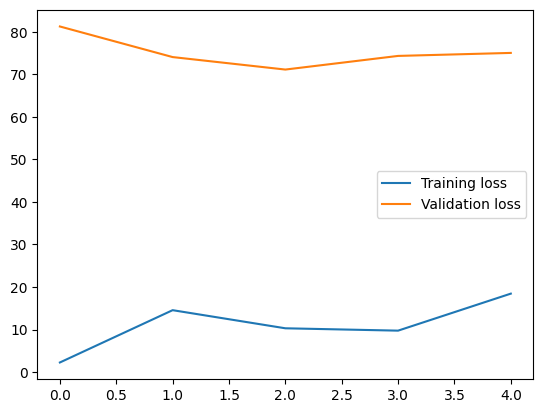

Test Loss: 75.04453948506138
Mean Squared Error: 130.35968
R2 Score: -0.6027313318783427
Mean Absolute Error: 9.067609
Test MSE: 130.35968
Test R2: -0.6027313318783427
Test MAE: 9.067609
Mean Absolute Error: 9.07
Accuracy: -inf %.
Mean Squared Error: 130.36
Root Mean Squared Error: 11.42
R2: -0.6


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


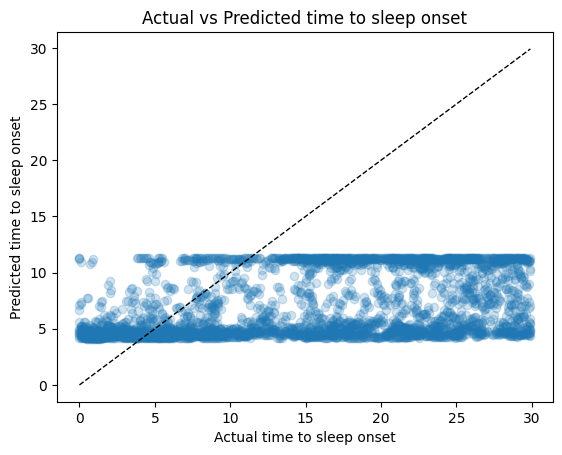

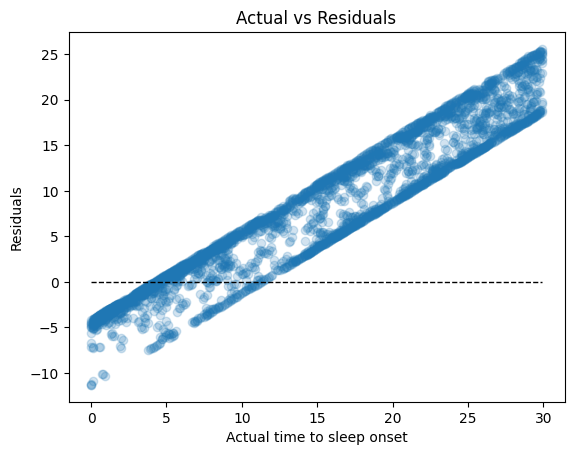

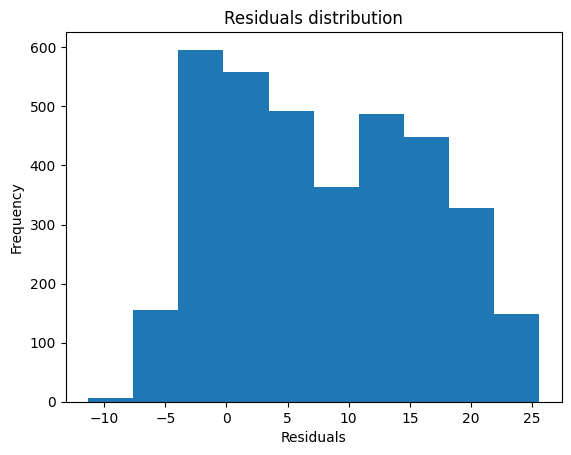

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


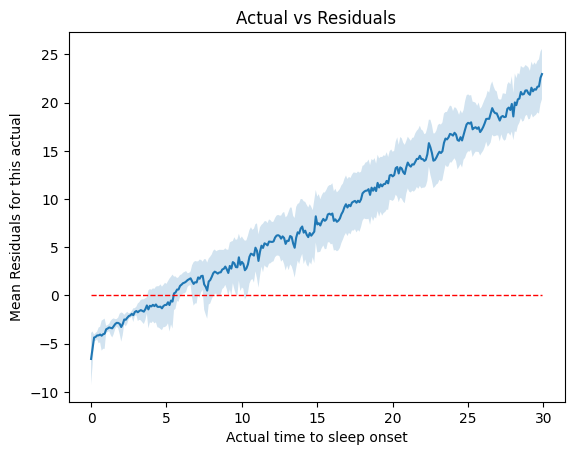

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


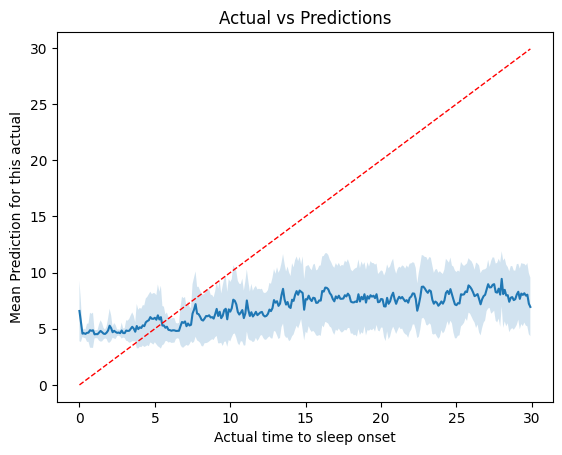

([2.254643678665161,
  14.553156852722168,
  10.293180465698242,
  9.739325523376465,
  18.44267463684082],
 [81.26059912798698,
  74.06601782012405,
  71.13106260801617,
  74.33876596417343,
  75.04453948506138],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
         )
         (linear1): Linear(in_features=512, out_features=2048, bias=True)
         (dropout): Dropout(p=0.0, inplace=False)
         (linear2): Linear(in_features=2048, out_features=512, bias=True)
         (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((512,), eps=1e-05, e

In [19]:
prioritize_onset_loss = CustomMSELoss()
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 5, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 64, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=False, ifoutputpredictions=0, 
                                         ifplot=True, ifsaveplots=True, output_path=None, loss_function=prioritize_onset_loss)

There are 193 subjects in the training set, 22 subjects in the validation set and 0 subjects in the test set
Epoch 1/15
----------------------------------------------------------------------------------------------------
Epoch 1/15, Loss: 9.751751899719238, Validation Loss: 72.50641154406364
Val Mean Squared Error: 122.89435577392578, Val R2 Score: -0.5109474741151367
Epoch 2/15
----------------------------------------------------------------------------------------------------
Epoch 2/15, Loss: 11.045016288757324, Validation Loss: 72.56818537126507
Val Mean Squared Error: 120.68052673339844, Val R2 Score: -0.48372925165211367
Epoch 3/15
----------------------------------------------------------------------------------------------------
Epoch 3/15, Loss: 5.584341526031494, Validation Loss: 71.07237614246837
Val Mean Squared Error: 119.41141510009766, Val R2 Score: -0.4681257420494638
Epoch 4/15
--------------------------------------------------------------------------------------------

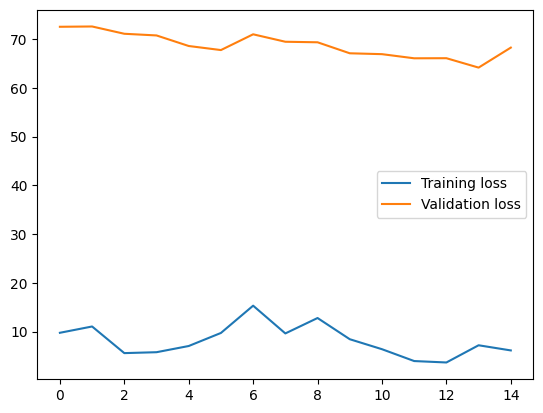

Test Loss: 68.2344836184853
Mean Squared Error: 110.663376
R2 Score: -0.36057146760688186
Mean Absolute Error: 8.319053
Test MSE: 110.663376
Test R2: -0.36057146760688186
Test MAE: 8.319053
Mean Absolute Error: 8.32
Accuracy: -inf %.
Mean Squared Error: 110.66
Root Mean Squared Error: 10.52
R2: -0.36


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


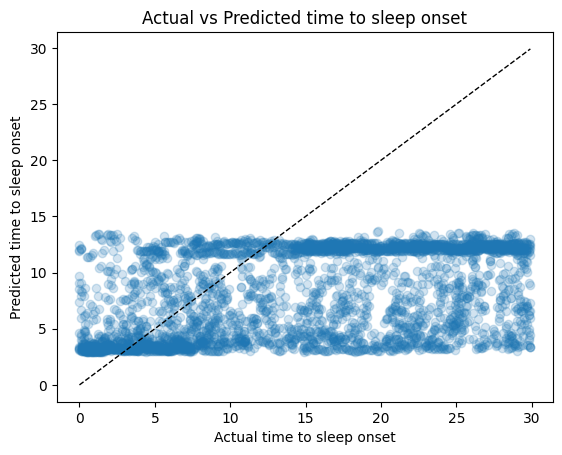

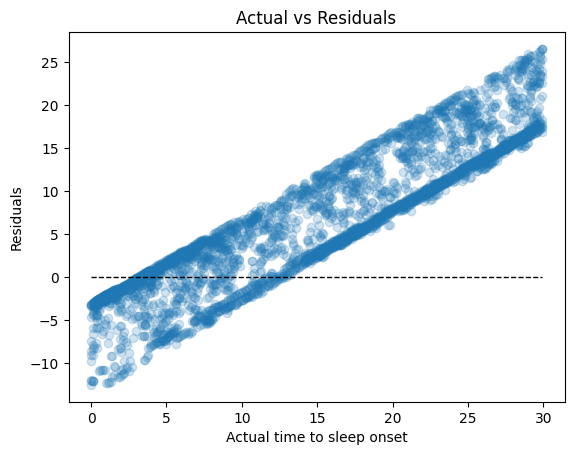

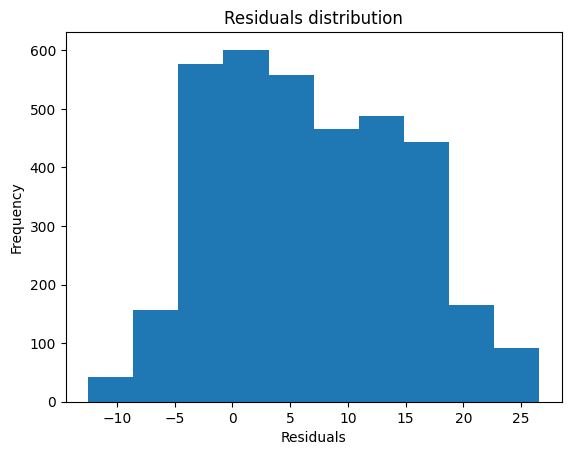

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


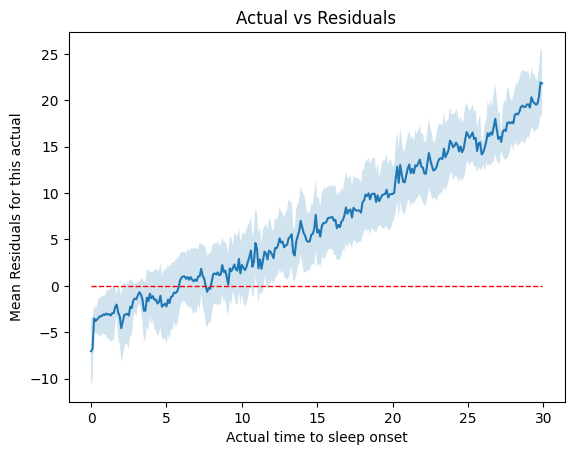

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


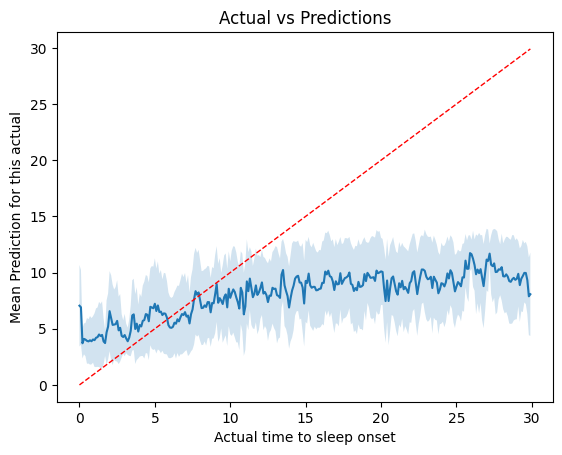

([9.751751899719238,
  11.045016288757324,
  5.584341526031494,
  5.7703399658203125,
  7.041615009307861,
  9.718907356262207,
  15.311559677124023,
  9.620882987976074,
  12.781289100646973,
  8.434130668640137,
  6.3870849609375,
  3.955839157104492,
  3.6640565395355225,
  7.192471981048584,
  6.135730266571045],
 [72.50641154406364,
  72.56818537126507,
  71.07237614246837,
  70.73004281729983,
  68.56343692645692,
  67.73087384407981,
  70.96315860748291,
  69.4360648874651,
  69.3254843594735,
  67.07049794782672,
  66.89174729899356,
  66.04323907902366,
  66.0617226675937,
  64.13483978990922,
  68.2344836184853],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (o

In [20]:
prioritize_onset_loss = CustomMSELoss(epsilon=0.1)
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 15, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 64, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=False, ifoutputpredictions=0, 
                                        ifplot=True, ifsaveplots=True, output_path=None, loss_function=prioritize_onset_loss)

There are 193 subjects in the training set, 22 subjects in the validation set and 0 subjects in the test set
Epoch 1/15
----------------------------------------------------------------------------------------------------
Epoch 1/15, Loss: 30.134408950805664, Validation Loss: 72.58948559596621
Val Mean Squared Error: 179.9147491455078, Val R2 Score: -1.2119952981478965
Epoch 2/15
----------------------------------------------------------------------------------------------------
Epoch 2/15, Loss: 24.30389404296875, Validation Loss: 63.89566151849155
Val Mean Squared Error: 156.14291381835938, Val R2 Score: -0.9197279158756368
Epoch 3/15
----------------------------------------------------------------------------------------------------
Epoch 3/15, Loss: 25.357423782348633, Validation Loss: 61.77121251204918
Val Mean Squared Error: 151.10696411132812, Val R2 Score: -0.8578127088382677
Epoch 4/15
---------------------------------------------------------------------------------------------

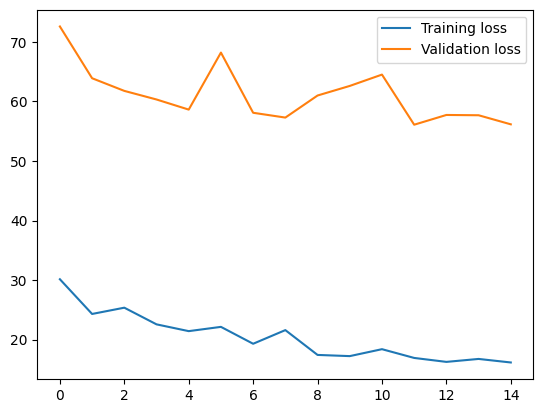

Test Loss: 56.15374857803871
Mean Squared Error: 122.310616
R2 Score: -0.5037706647655882
Mean Absolute Error: 8.695811
Test MSE: 122.310616
Test R2: -0.5037706647655882
Test MAE: 8.695811
Mean Absolute Error: 8.7
Accuracy: -inf %.
Mean Squared Error: 122.31
Root Mean Squared Error: 11.06
R2: -0.5


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


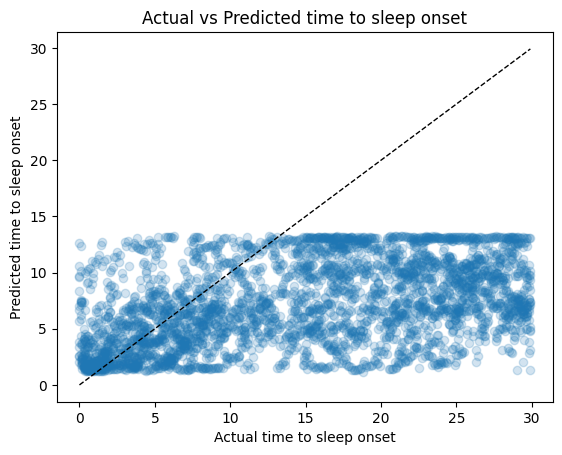

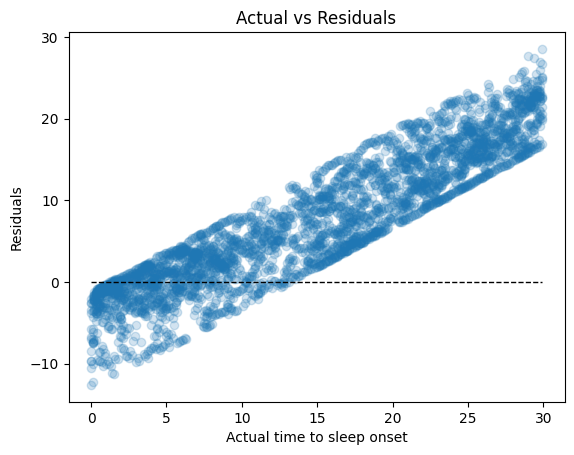

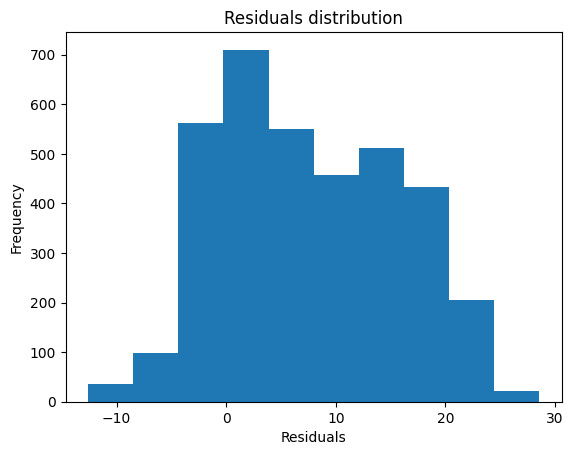

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


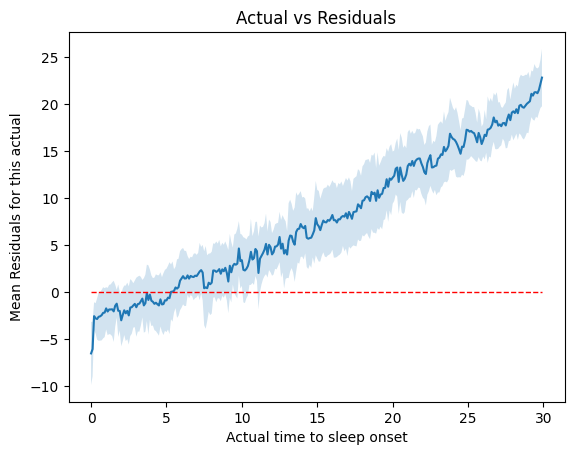

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


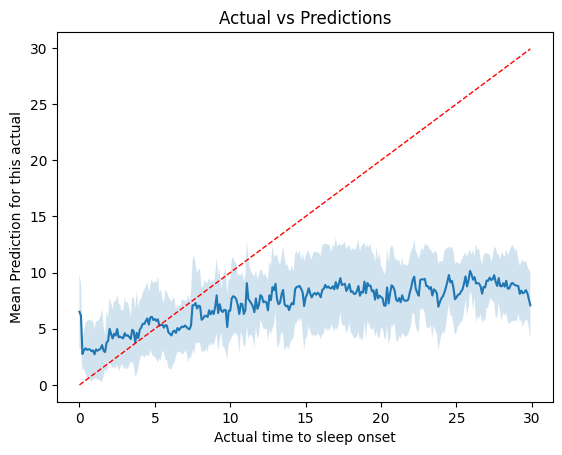

([30.134408950805664,
  24.30389404296875,
  25.357423782348633,
  22.55851936340332,
  21.418758392333984,
  22.135456085205078,
  19.298017501831055,
  21.59176254272461,
  17.42300796508789,
  17.223468780517578,
  18.388090133666992,
  16.917211532592773,
  16.254085540771484,
  16.749835968017578,
  16.154977798461914],
 [72.58948559596621,
  63.89566151849155,
  61.77121251204918,
  60.32644245542329,
  58.62728812776763,
  68.20638590845569,
  58.095297484562316,
  57.288541432084706,
  60.9943046240971,
  62.604586831454576,
  64.50805489770298,
  56.09094685521619,
  57.72774913393218,
  57.6786103741876,
  56.15374857803871],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(


In [21]:
prioritize_onset_loss = CustomMSELoss(epsilon=0.1)
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 15, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 128, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=False, ifoutputpredictions=0, 
                                        ifplot=True, ifsaveplots=True, output_path=None, loss_function=prioritize_onset_loss)

## Another Custom loss, which is even more weighted towards the smaller values

In [22]:
import torch
import torch.nn as nn

class CustomMSELossSquared(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(CustomMSELossSquared, self).__init__()
        self.epsilon = epsilon  # Small value to prevent division by zero

    def forward(self, predictions, targets):
        # Compute error
        errors = (predictions - targets)**2

        # Compute weights inversely proportional to target values
        weights = 1.0 / (torch.abs(targets) + self.epsilon)**2

        # Weighted sum of errors
        loss = torch.sum(weights * errors) / torch.sum(weights)
        return loss

# Test the custom loss
predictions = torch.tensor([0.5, 0.2, 0.7])
targets = torch.tensor([0.1, 0.4, 0.8])
criterion = CustomMSELossSquared()
loss = criterion(predictions, targets)
print(loss)


tensor(0.1509)


There are 193 subjects in the training set, 22 subjects in the validation set and 0 subjects in the test set
Epoch 1/16
----------------------------------------------------------------------------------------------------
Epoch 1/16, Loss: 26.21622085571289, Validation Loss: 43.670637565207315
Val Mean Squared Error: 293.45751953125, Val R2 Score: -2.60796796425096
Epoch 2/16
----------------------------------------------------------------------------------------------------
Epoch 2/16, Loss: 20.92374038696289, Validation Loss: 40.477737517192445
Val Mean Squared Error: 274.0807800292969, Val R2 Score: -2.369737012115319
Epoch 3/16
----------------------------------------------------------------------------------------------------
Epoch 3/16, Loss: 20.401762008666992, Validation Loss: 40.332921777305934
Val Mean Squared Error: 272.06884765625, Val R2 Score: -2.3450010744832306
Epoch 4/16
----------------------------------------------------------------------------------------------------

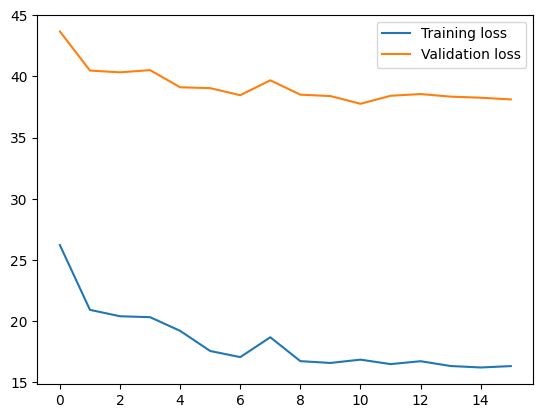

Test Loss: 38.11876236981359
Mean Squared Error: 250.0031
R2 Score: -2.073709521784
Mean Absolute Error: 13.127295
Test MSE: 250.0031
Test R2: -2.073709521784
Test MAE: 13.127295
Mean Absolute Error: 13.13
Accuracy: -inf %.
Mean Squared Error: 250.0
Root Mean Squared Error: 15.81
R2: -2.07


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


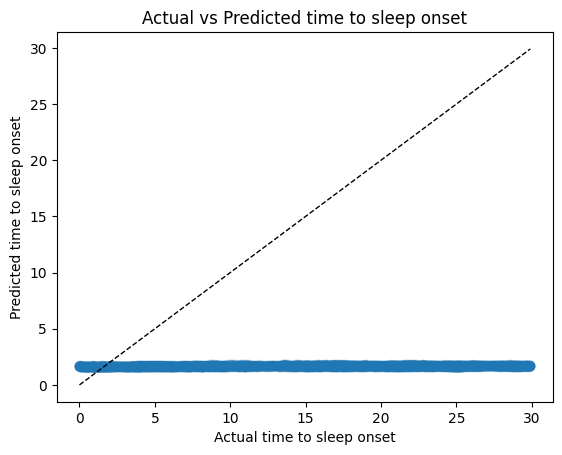

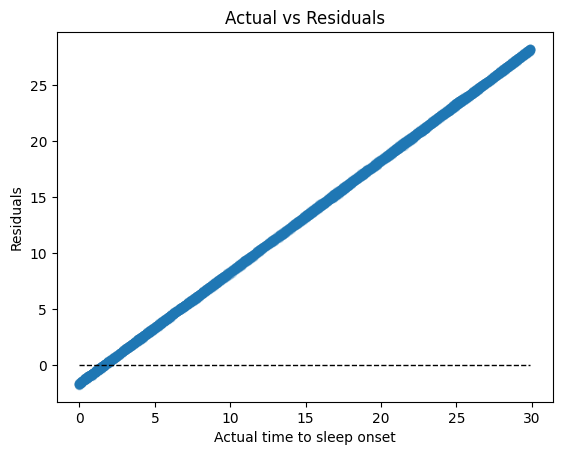

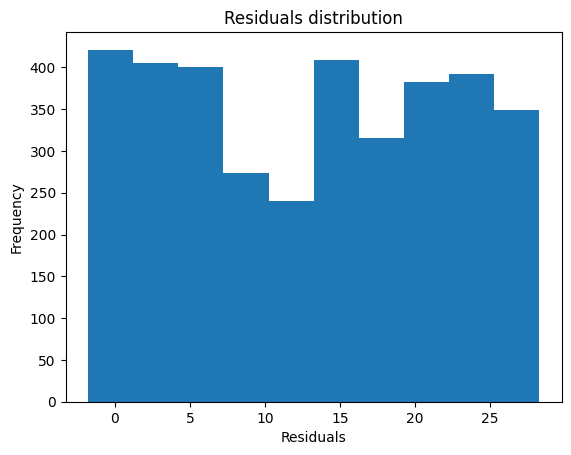

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


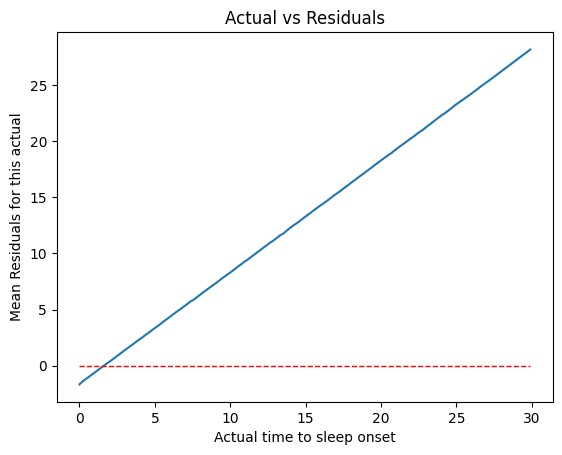

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


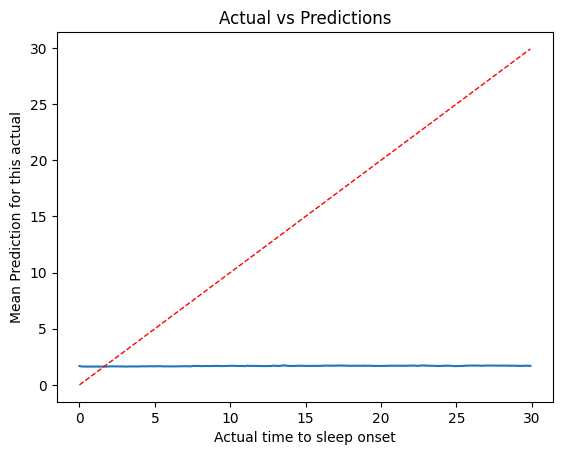

([26.21622085571289,
  20.92374038696289,
  20.401762008666992,
  20.32503890991211,
  19.208261489868164,
  17.562591552734375,
  17.062021255493164,
  18.68313217163086,
  16.73216438293457,
  16.586149215698242,
  16.85634422302246,
  16.491199493408203,
  16.727689743041992,
  16.335474014282227,
  16.215730667114258,
  16.328214645385742],
 [43.670637565207315,
  40.477737517192445,
  40.332921777305934,
  40.512459430201304,
  39.11099767171103,
  39.04212155424315,
  38.4629632399,
  39.68023894162014,
  38.50600667657523,
  38.39361519649111,
  37.76266569926821,
  38.4161773467886,
  38.55711786500339,
  38.34585320538488,
  38.25844982574726,
  38.11876236981359],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
   

In [23]:

training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 16, l2 = 0, lr = 0.0001, weight_decay =0.5, batch_size = 128, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=False, ifoutputpredictions=0, 
                                        ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELossSquared())

There are 193 subjects in the training set, 22 subjects in the validation set and 0 subjects in the test set
Epoch 1/16
----------------------------------------------------------------------------------------------------
Epoch 1/16, Loss: 99.21414947509766, Validation Loss: 5.906824438770612
Val Mean Squared Error: 292.2897033691406, Val R2 Score: -2.384878957154937
Epoch 2/16
----------------------------------------------------------------------------------------------------
Epoch 2/16, Loss: 93.02180480957031, Validation Loss: 5.793450813988844
Val Mean Squared Error: 284.2535705566406, Val R2 Score: -2.291815485449773
Epoch 3/16
----------------------------------------------------------------------------------------------------
Epoch 3/16, Loss: 97.95185852050781, Validation Loss: 5.863326116402944
Val Mean Squared Error: 288.59210205078125, Val R2 Score: -2.3420586453335073
Epoch 4/16
--------------------------------------------------------------------------------------------------

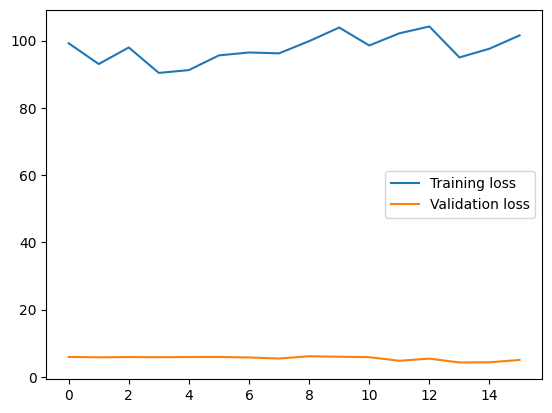

Test Loss: 5.012639129627496
Mean Squared Error: 279.20215
R2 Score: -2.2333174744291404
Mean Absolute Error: 14.134678
Test MSE: 279.20215
Test R2: -2.2333174744291404
Test MAE: 14.134678
Mean Absolute Error: 14.13
Accuracy: -inf %.
Mean Squared Error: 279.2
Root Mean Squared Error: 16.71
R2: -2.23


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


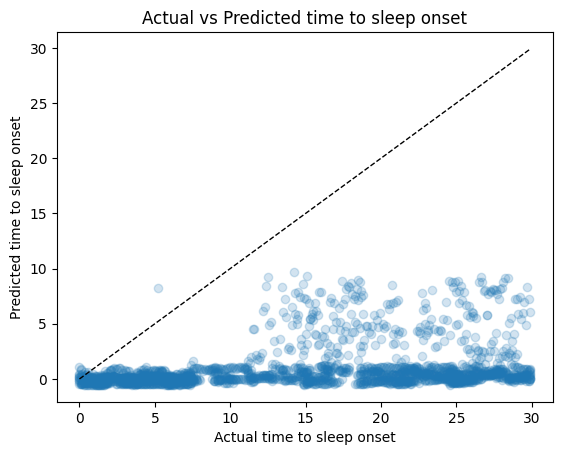

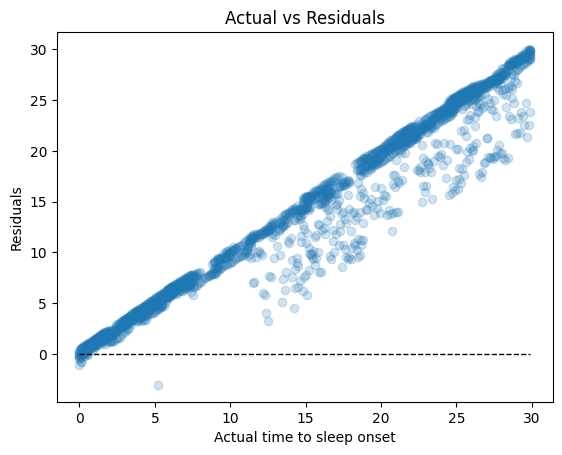

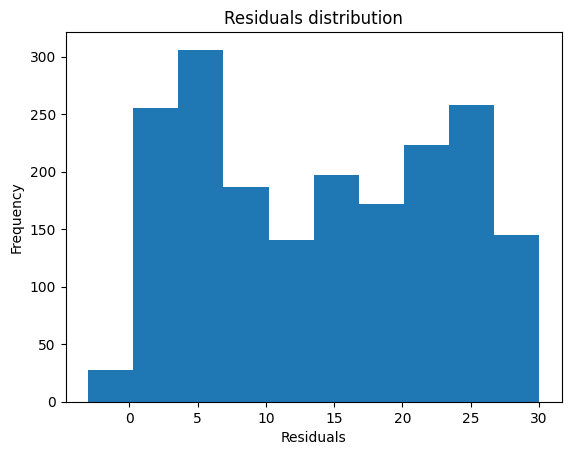

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


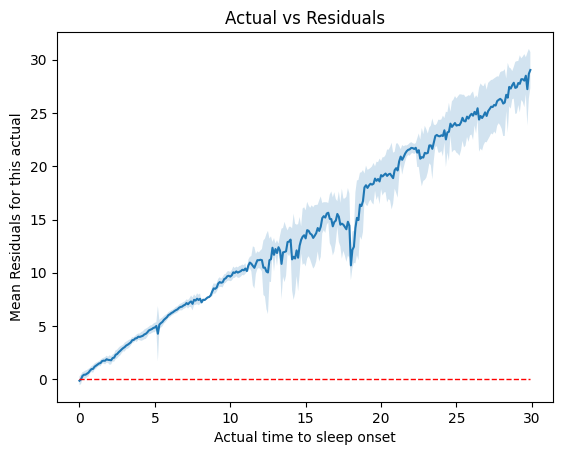

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


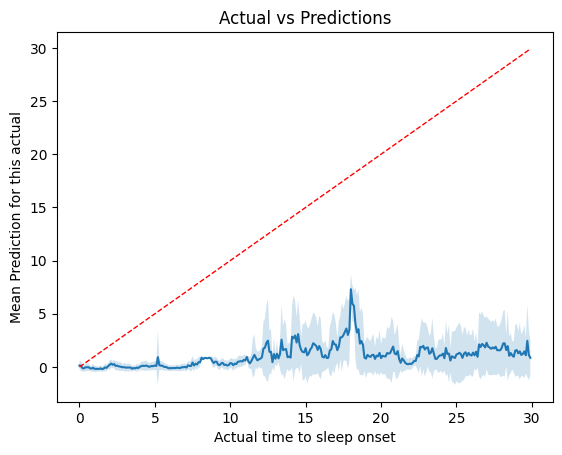

([99.21414947509766,
  93.02180480957031,
  97.95185852050781,
  90.38313293457031,
  91.22540283203125,
  95.60240173339844,
  96.4609603881836,
  96.20349884033203,
  99.832275390625,
  103.88077545166016,
  98.54258728027344,
  102.15523529052734,
  104.19526672363281,
  94.99114227294922,
  97.58574676513672,
  101.54254150390625],
 [5.906824438770612,
  5.793450813988844,
  5.863326116402944,
  5.824409159024556,
  5.866189996401469,
  5.892140439152717,
  5.750699910521507,
  5.434386817365885,
  6.1051534635325275,
  5.960067664381738,
  5.8322993684948115,
  4.762690703563082,
  5.394354636363498,
  4.255711467005312,
  4.311025569580185,
  5.012639129627496],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         

In [24]:

training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 16, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 128, device = device, 
                                        random_seed=42, window_size_minutes=3, iftest=False, ifoutputpredictions=0, 
                                        ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELossSquared())

There are 193 subjects in the training set, 22 subjects in the validation set and 0 subjects in the test set
Epoch 1/15
----------------------------------------------------------------------------------------------------
Epoch 1/15, Loss: 72.26249694824219, Validation Loss: 33.124615001678464
Val Mean Squared Error: 243.692138671875, Val R2 Score: -1.8220916862949936
Epoch 2/15
----------------------------------------------------------------------------------------------------
Epoch 2/15, Loss: 85.43038940429688, Validation Loss: 33.67236852645874
Val Mean Squared Error: 263.6782531738281, Val R2 Score: -2.0535419683669387
Epoch 3/15
----------------------------------------------------------------------------------------------------
Epoch 3/15, Loss: 81.583984375, Validation Loss: 33.491450532277426
Val Mean Squared Error: 260.1203308105469, Val R2 Score: -2.0123395753021196
Epoch 4/15
----------------------------------------------------------------------------------------------------


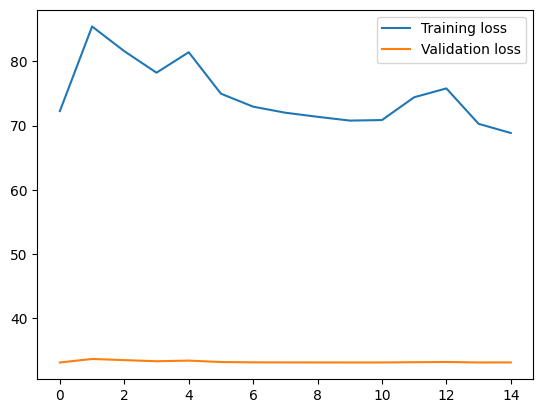

Test Loss: 33.13310791651408
Mean Squared Error: 242.05057
R2 Score: -1.8030815070010426
Mean Absolute Error: 12.760528
Test MSE: 242.05057
Test R2: -1.8030815070010426
Test MAE: 12.760528
Mean Absolute Error: 12.76
Accuracy: -inf %.
Mean Squared Error: 242.05
Root Mean Squared Error: 15.56
R2: -1.8


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


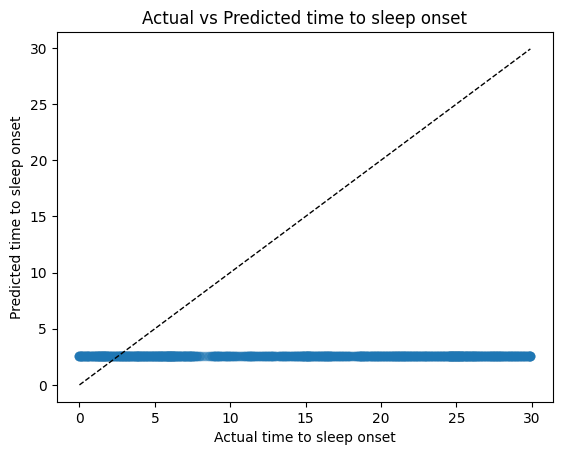

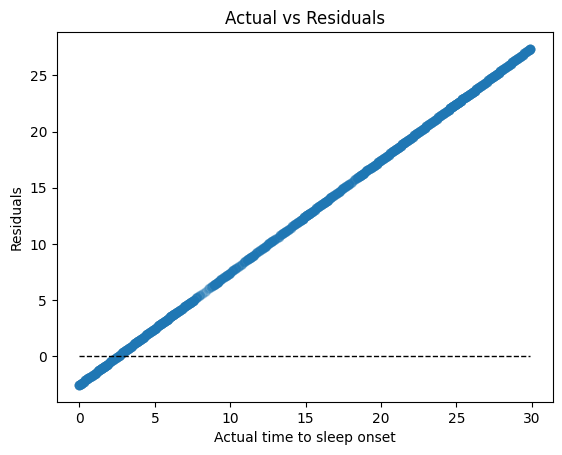

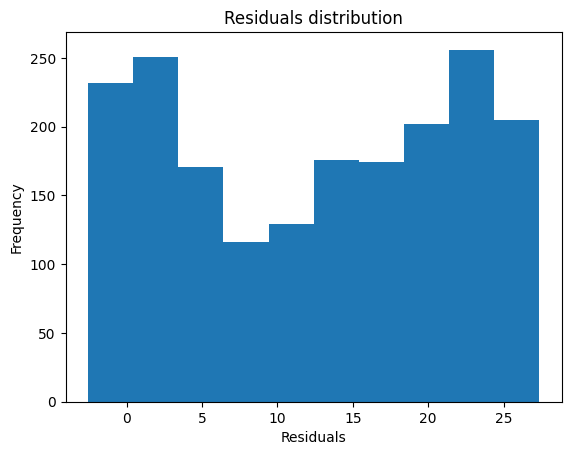

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


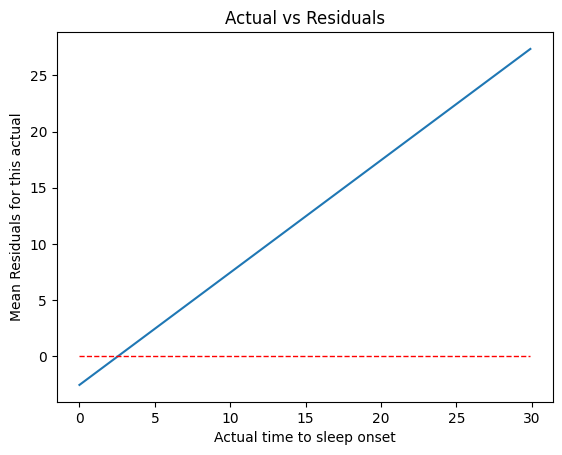

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


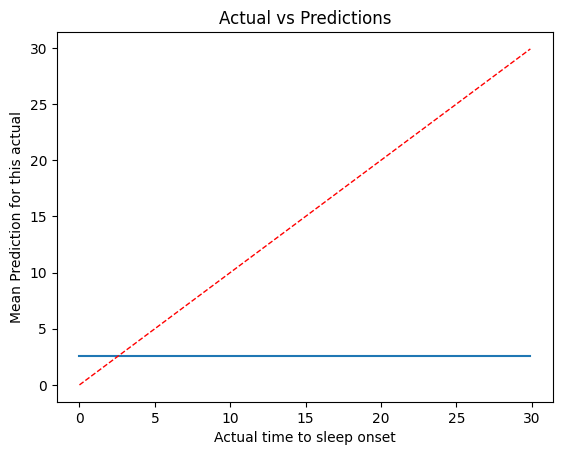

([72.26249694824219,
  85.43038940429688,
  81.583984375,
  78.23582458496094,
  81.41976928710938,
  74.96839141845703,
  72.9471206665039,
  72.0059814453125,
  71.37028503417969,
  70.78083038330078,
  70.86116027832031,
  74.41345977783203,
  75.78768920898438,
  70.27430725097656,
  68.84722900390625],
 [33.124615001678464,
  33.67236852645874,
  33.491450532277426,
  33.31575530370076,
  33.414205423990886,
  33.19232209523519,
  33.145073572794594,
  33.13208106358846,
  33.12654412587484,
  33.12395947774251,
  33.124030367533365,
  33.16631558736165,
  33.20120747884115,
  33.12382405598958,
  33.13310791651408],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (ou

In [25]:

training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 15, l2 = 0, lr = 0.01, weight_decay = 0.01, batch_size = 128, device = device, 
                                        random_seed=42, window_size_minutes=3, iftest=False, ifoutputpredictions=0, 
                                        ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELoss())

## Try to shuffle the training data

There are 193 subjects in the training set, 22 subjects in the validation set and 0 subjects in the test set
Epoch 1/30
----------------------------------------------------------------------------------------------------
Epoch 1/30, Loss: 51.43020248413086, Validation Loss: 33.20868844985962
Val Mean Squared Error: 251.9248809814453, Val R2 Score: -1.9174314088150788
Epoch 2/30
----------------------------------------------------------------------------------------------------
Epoch 2/30, Loss: 10.492232322692871, Validation Loss: 33.681745847066246
Val Mean Squared Error: 226.2621307373047, Val R2 Score: -1.6202424151383923
Epoch 3/30
----------------------------------------------------------------------------------------------------
Epoch 3/30, Loss: 41.06904220581055, Validation Loss: 33.12401396433513
Val Mean Squared Error: 245.1171875, Val R2 Score: -1.8385945542196227
Epoch 4/30
----------------------------------------------------------------------------------------------------


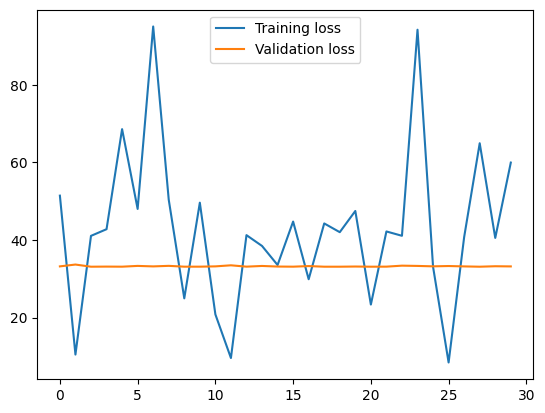

Test Loss: 33.20077466964722
Mean Squared Error: 251.56279
R2 Score: -1.913238381220379
Mean Absolute Error: 13.061397
Test MSE: 251.56279
Test R2: -1.913238381220379
Test MAE: 13.061397
Mean Absolute Error: 13.06
Accuracy: -inf %.
Mean Squared Error: 251.56
Root Mean Squared Error: 15.86
R2: -1.91


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


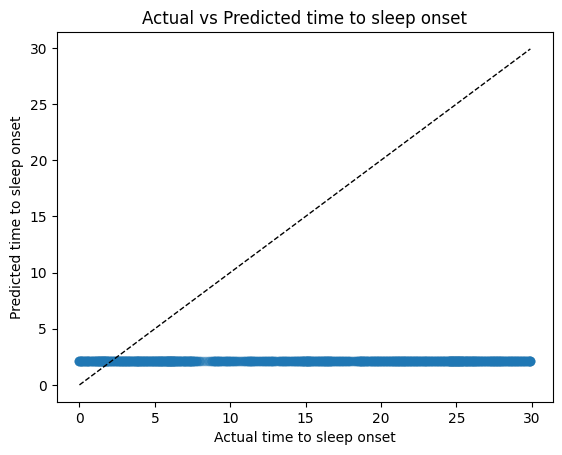

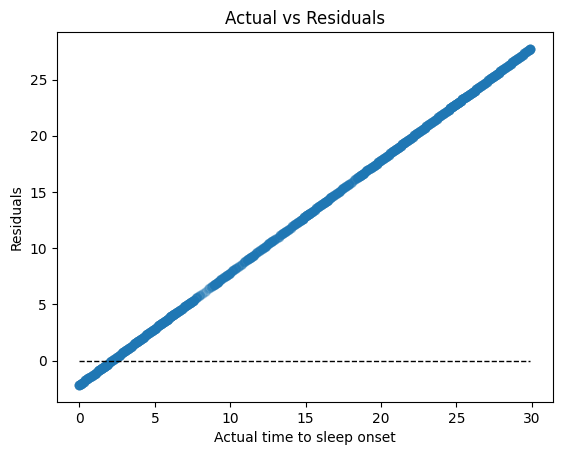

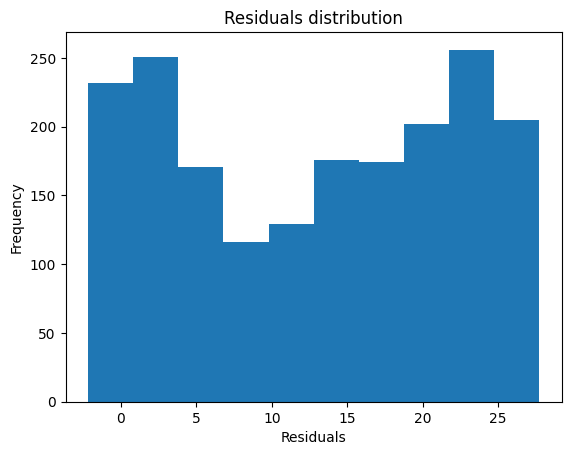

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


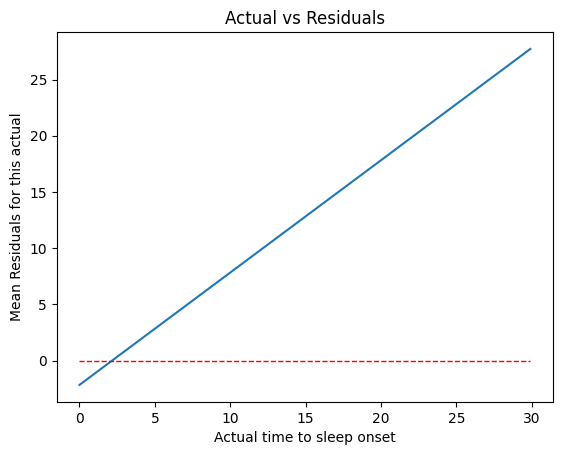

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


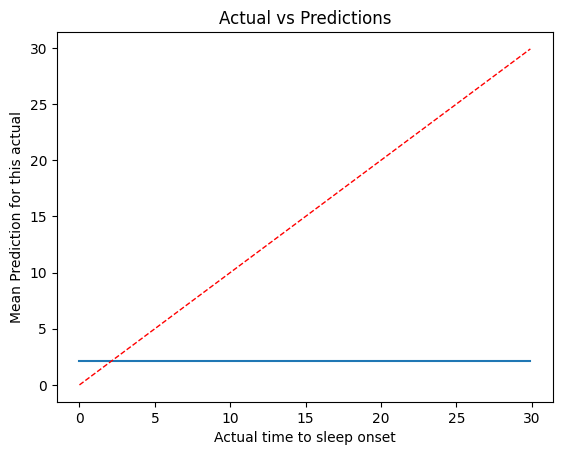

([51.43020248413086,
  10.492232322692871,
  41.06904220581055,
  42.78641128540039,
  68.56690979003906,
  48.00821304321289,
  95.0075454711914,
  50.39751052856445,
  24.975461959838867,
  49.61830139160156,
  20.84235382080078,
  9.601176261901855,
  41.256263732910156,
  38.472660064697266,
  33.56098556518555,
  44.7535285949707,
  29.895414352416992,
  44.27312469482422,
  42.01863098144531,
  47.48339080810547,
  23.372583389282227,
  42.20616912841797,
  41.08745193481445,
  94.17440795898438,
  33.09294509887695,
  8.453838348388672,
  40.752811431884766,
  64.92681884765625,
  40.536067962646484,
  59.94903564453125],
 [33.20868844985962,
  33.681745847066246,
  33.12401396433513,
  33.152973906199136,
  33.130823802948,
  33.330403645833336,
  33.20479294459025,
  33.34472077687581,
  33.13342437744141,
  33.133744875590004,
  33.2110398610433,
  33.48367799123128,
  33.13953205744426,
  33.319098981221515,
  33.16396640141805,
  33.132880147298174,
  33.28571402231852,
  3

In [26]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 30, l2 = 0, lr = 0.001, weight_decay = 0.05, batch_size = 128, device = device, 
                                        random_seed=42, window_size_minutes=3, iftest=False, ifoutputpredictions=0, 
                                       ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELoss(), iftrainshuffle=True)

There are 193 subjects in the training set, 22 subjects in the validation set and 0 subjects in the test set
Epoch 1/16
----------------------------------------------------------------------------------------------------
Epoch 1/16, Loss: 65.44124603271484, Validation Loss: 47.83604408303896
Val Mean Squared Error: 207.23497009277344, Val R2 Score: -1.6109143660726737
Epoch 2/16
----------------------------------------------------------------------------------------------------
Epoch 2/16, Loss: 52.0700798034668, Validation Loss: 47.496791058116486
Val Mean Squared Error: 194.19937133789062, Val R2 Score: -1.4466812319397389
Epoch 3/16
----------------------------------------------------------------------------------------------------
Epoch 3/16, Loss: 50.14806365966797, Validation Loss: 48.53312276469337
Val Mean Squared Error: 142.51980590820312, Val R2 Score: -0.7955801596227288
Epoch 4/16
----------------------------------------------------------------------------------------------

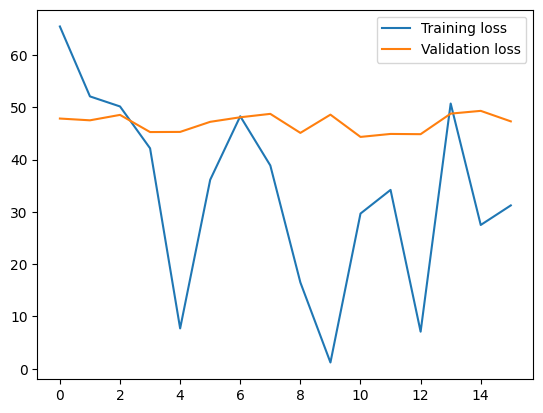

Test Loss: 47.29507804910342
Mean Squared Error: 195.61864
R2 Score: -1.464562137317278
Mean Absolute Error: 11.4144125
Test MSE: 195.61864
Test R2: -1.464562137317278
Test MAE: 11.4144125
Mean Absolute Error: 11.41
Accuracy: -inf %.
Mean Squared Error: 195.62
Root Mean Squared Error: 13.99
R2: -1.46


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


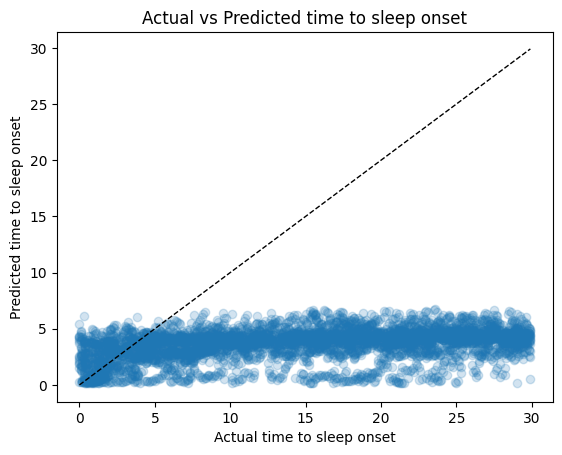

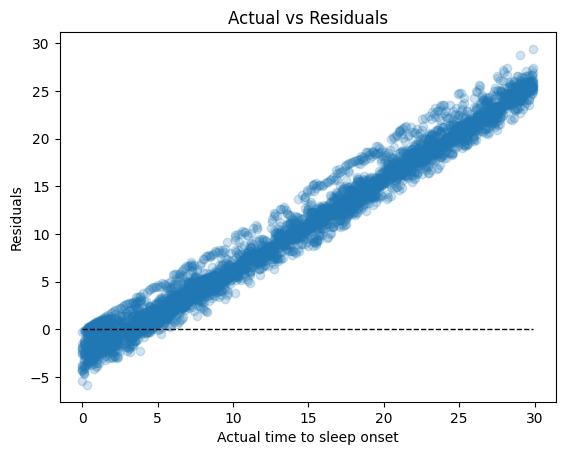

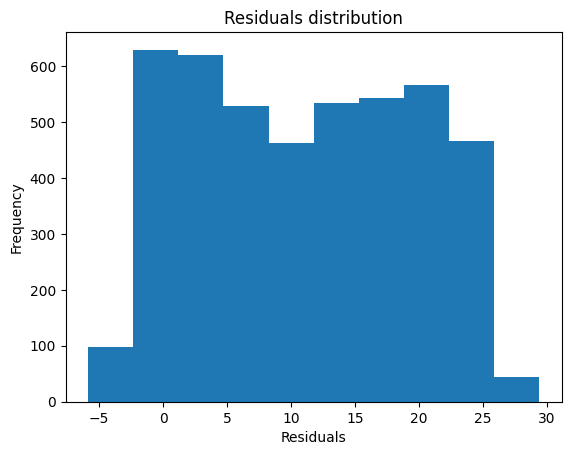

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


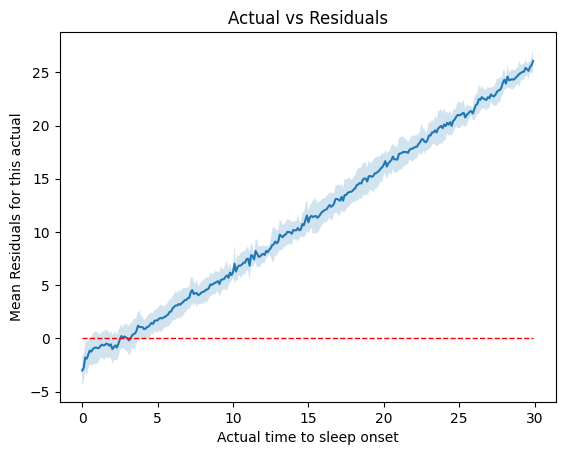

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_71892/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


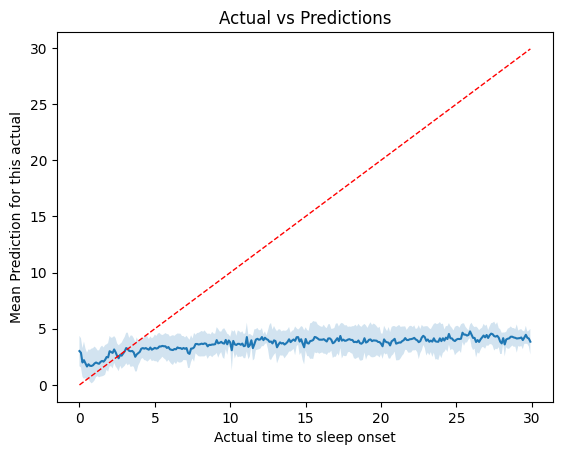

([65.44124603271484,
  52.0700798034668,
  50.14806365966797,
  42.143035888671875,
  7.701663017272949,
  36.12250518798828,
  48.27621078491211,
  38.860164642333984,
  16.491981506347656,
  1.1894220113754272,
  29.665035247802734,
  34.190059661865234,
  7.074708938598633,
  50.70795822143555,
  27.484373092651367,
  31.225421905517578],
 [47.83604408303896,
  47.496791058116486,
  48.53312276469337,
  45.25120704372724,
  45.28028155035443,
  47.20853139460087,
  48.078468341276874,
  48.730856001377106,
  45.09295826488071,
  48.58034245090352,
  44.322362853421104,
  44.892441027694275,
  44.84651065203879,
  48.777995589706634,
  49.305216524336075,
  47.29507804910342],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer

In [27]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 16, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 128, device = device, 
                                        random_seed=42, window_size_minutes=0.5, iftest=False, ifoutputpredictions=0, 
                                         ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELoss(), iftrainshuffle=True)